In [1]:
################################ EDA IMPORTS ###################################
%matplotlib inline
import pandas as pd 
import pandas_profiling # Quick Data Analysis
import numpy as np # Linear Algebra lib
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions
# ---------------- Plot libs settings ------------- #
# Pick style of Matplolib plots 
# Different style sheets:-> https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
# Configure Seaborn Asthetics: -> https://seaborn.pydata.org/tutorial/aesthetics.html?highlight=style
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')
# Seting a universal figure size 
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- Pandas settings ------------- #
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

################################################################################
############################# Ignore the warnings ##############################
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

################################################################################

In [2]:
def download_raw_data_from_s3():
    !rm -rf '../datasets/dirty-data'
    #!rm -rf '../datasets/clean-data'
    !mkdir -p '../datasets/dirty-data'
    #!mkdir -p '../datasets/clean-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_kakao_2019-08-26_02PM.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_psn_2019-08-26_01PM.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_steam_2019-08-26_01PM.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_xbox_2019-08-26_02PM.csv' -P '../datasets/dirty-data'
    
download_raw_data_from_s3()

--2019-08-29 17:25:47--  https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats.csv
Resolving project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)... 52.219.88.88
Connecting to project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)|52.219.88.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16665366 (16M) [text/csv]
Saving to: ‘../datasets/dirty-data/pubg_stats.csv’

pubg_stats.csv      100%[===================>]  15.89M  57.6MB/s    in 0.3s    

2019-08-29 17:25:48 (57.6 MB/s) - ‘../datasets/dirty-data/pubg_stats.csv’ saved [16665366/16665366]

--2019-08-29 17:25:48--  https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_kakao_2019-08-26_02PM.csv
Resolving project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)... 52.219.100.32
Connecting to project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)|52.219.100.32|:443... co

## Project PUBG 🤖💣💥🔫🤖 


### So, where we droppin' boys and girls?
PUBG or Player Unknown Battlegrounds is a battle-royale style game where at the beginning of the play, nearly 100 people parachute onto an island without any equipment. In order to win the game, you need to scavenge for weapons and available equipment to eliminate the other people and survive to the end. The game also restricts player in Hunger Game style by reducing the playable are in map after a some amount of fixed time is passed. 

### Objective

**Defining the problem:** The problem we have is, there is not set guide or strategy to improve player performance in PUBG, should your play style be stealth like a ninja and sneak upon unsuspecting players, or by camping in one spot and hide your way into victory, or snipe like assassin, or do you need to be aggressive and play like Rambo?  

**Solution:** Is to create a web application that allows players to improve their strategy by considering *What-if* scenarios as MVP.

**Restrictions:** To keep the project simple and meaningful, we would need to keep game mode, and map types restricted, remove any outliers (aka cheaters) and players that logged-in but didn't play. 


### Data Mining

The team at [PUBG](https://www.pubg.com/) has made official game data available for the public to explore and scavenge outside of "The Blue Circle." 

Process:

- Using [PUBG DEVELOPER API](https://documentation.pubg.com/) we can mine the necessary data of player matches from different **platforms**:
    - **steam**
    - **psn**
    - **xbox**
    - **kakao**
    
- Using `/samples` API endpoint we will collect sample matches from each platform, merge them, and remove any identifiable information of player like their PUBG IGN, add some features for feature engineering, with Quick EDA.


![](https://d.newsweek.com/en/full/854048/pubg-logo.jpg)


## [Contents](#)


### [Data Dictionary](#Data-Dictionary)

### [Extract, Transform, Load](#Extract,-Transform,-Load)
  - #### [Load](#Load)
  - #### [Transform](#Transform)
  
### [Train, Validate, Test Split](#Train,-Validate,-Test-Split)

### [EDA and Data Wrangling](#EDA-and-Data-Wrangling)
 - #### [Descriptive Statistics](#Descriptive-Statistics)
 - #### [Single Variable Analysis](#Single-Variable-Analysis)
 - #### [Pairwise Analysis](#Pairwise-Analysis)
 - #### [Correlations](#Correlations)

### [Baseline](#Baseline)
 - #### [Mean](#Mean)
 - #### [Linear Regression](#Linear-Regression)
 - #### [Random Forest](#Random-Forest)

###  [Data Dictionary](#Contents)


Below is data description from [`matches` API endpoint documentation](https://documentation.pubg.com/en/matches-endpoint.html)

- `DBNOs` - Down But Not Out - Number of enemy players knocked.
- `assists` - Number of enemy players this player damaged that were killed by teammates.
- `boosts` - Number of boost items used (i.e. energy drinks - which increases player's boost by 40, granting health regeneration, increase movement and speed.)
- `damageDealt` - Total damage dealt. Note: Self inflicted damage is subtracted.
- `deathType` - If player killed another player or by their teammates or self-inflicted death (i.e. suicide) ⚠️ **NOTE: Causes leakage, as player is alive than they by default won the game, something that can be known only after the game.**
- `duration` - Duration of match in seconds.
- `gameMode` - String identifying the game mode that the data comes from. The standard modes are:
    -`solo` or `solo-fpp` (FPP - First Person Player)
    - `duo` or `duo-fpp`
    - `squad` or `squad-fpp`
    and other modes are from events or custom matches.
- `headshotKills` - Number of enemy players killed with headshots.
- `heals` - Number of healing items used.
- `killPlace` - Ranking in match of number of enemy players killed, min. 1, max. 130. ⚠️ **NOTE: Using it would cause target leakage as this stat. is collected after gameplay.**
- `killStreaks` - Max number of enemy players killed in a short amount of time.
- `kills` - Number of enemy players killed.
- `longestKill` - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- `mapName` - There are 4 main type of maps:
    - Erangel 
    - Desert (Miramar)
    - Savage (Sanhok)
    - Snow (Vikendi) 
**Any other maps, like `Training`, or custom ones should be removed**.
- `matchId` - ID to identify match. There are no matches that are in both the training and testing set. 
- `name` - PUGB player id 🚫 **this would be removed to preserve player anonymity**
- `playerId` - id of the player 
- `revives` - Number of times this player revived teammates.
- `rideDistance` - Total distance traveled in vehicles measured in meters.
- `roadKills` - Number of kills while in a vehicle.
- `swimDistance` - Total distance traveled by swimming measured in meters.
- `teamKills` - Number of times this player killed a teammate.
- `timeSurvived` - Amount of time survived measured in seconds
- `vehicleDestroys` - Number of vehicles destroyed.
- `walkDistance` - Total distance traveled on foot measured in meters.
- `weaponsAcquired` - Number of weapons picked up.
- `winPlace` - This player's placement in the match, which would be our target.

### [Extract, Transform, Load](#Contents)

In [3]:
#################################### CUSTOM API IMPORTS #######################
import sys, os
sys.path.insert(len(sys.path)-1, os.path.dirname(os.getcwd()))
from pubg import helper
from pubg import eda
###############################################################################

#### [Load](#Contents)

In [4]:
dirty_data_dir = '../datasets/dirty-data'

dfs = []
for file in os.listdir(dirty_data_dir):
    file_path = os.path.join(dirty_data_dir, file)
    df = helper.load_dataset(file_path, verbose=True)
    dfs.append(df)

Memory usage of dataframe is 13.22 MB
Memory usage after optimization is: 4.96 MB
Decreased by 62.5%

        -------------------- SHAPE ---------------------
        DF pubg_stats_xbox_2019-08-26_02PM.csv: (61874, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 17.83 MB
Memory usage after optimization is: 6.69 MB
Decreased by 62.5%

        -------------------- SHAPE ---------------------
        DF pubg_stats.csv: (83480, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 26.57 MB
Memory usage after optimization is: 10.08 MB
Decreased by 62.1%

        -------------------- SHAPE ---------------------
        DF pubg_stats_steam_2019-08-26_01PM.csv: (124395, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 10.61 MB
Memory usage after optimization is: 3.98 MB
Decreased by 62.5%

        -------------------- SHAPE ---------------------
    

####   <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Steam_icon_logo.svg/1200px-Steam_icon_logo.svg.png' width=32 height=32 align='left'> 

In [5]:
# Individual shapes are: 
dfs[1].shape, dfs[2].shape

((83480, 28), (124395, 28))

In [6]:
# Assert total rows 8,3480 + 124,395 = 207,875
assert dfs[1].shape[0] + dfs[2].shape[0] == 207875

steam = pd.concat([dfs[1], dfs[2]], ignore_index=True, verify_integrity=True)

assert steam.shape[0] == 207875

# Assert total cols 28 == 28
assert dfs[0].shape[1] == steam.shape[1]

steam.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,1,2,0,118.5625,byplayer,1787,squad,0,0,35,1,1,8.742188,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,CoreyMrT,steam,account.e8dec15d50f44b33b5ecbd77b4498efe,0,0.0,0,0.0,0,375.25,0,417.75,4,22
1,0,0,5,166.0000,byplayer,1787,squad,0,1,11,1,2,120.562500,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,MichaelTX254,steam,account.83e9e5bd6566499da1cc5f185c43eb74,1,3156.0,0,0.0,0,1421.00,0,2608.00,5,5
2,2,1,4,266.0000,byplayer,1787,squad,0,5,7,2,3,23.062500,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,Dr_Matasanos,steam,account.97dc2011adfe4c75879743f83903fb59,0,2846.0,0,0.0,0,1400.00,0,3002.00,4,6
3,1,5,3,417.2500,byzone,1787,squad,0,0,5,2,3,270.500000,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,Pray_GM,steam,account.3d478dcf49f449b3a42e84063a621074,0,1302.0,0,0.0,0,1549.00,1,2676.00,7,1
4,1,0,0,18.0000,byplayer,1787,squad,0,0,84,0,0,0.000000,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,ComicBooksPlus,steam,account.534f2b758b01409681fe3c4313ad270a,0,0.0,0,0.0,0,301.50,0,530.00,3,24


In [7]:
steam.tail()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
207870,0,0,1,0.00,byplayer,1697,squad-fpp,0,0,49,0,0,0.0000,Baltic_Main,5b7c2033-52dc-4af0-aef5-771857924249,ASergey,steam,account.10a8ce6bd6194d979ab2d89825988e46,1,2974.0,0,27.625,0,925.5,1,2060.0,3,11
207871,3,0,6,256.25,byplayer,1697,squad-fpp,0,31,5,2,3,36.6875,Baltic_Main,5b7c2033-52dc-4af0-aef5-771857924249,MAG95,steam,account.3c55c48a43324e259834530fd75617f9,1,5872.0,0,0.000,0,1681.0,0,3086.0,6,2
207872,0,0,2,0.00,byplayer,1697,squad-fpp,0,16,47,0,0,0.0000,Baltic_Main,5b7c2033-52dc-4af0-aef5-771857924249,SuN_OF_THE_SUN,steam,account.4f074e35e45c4e8a9ad13ded92ba26d1,0,8200.0,0,37.000,0,1048.0,0,904.5,8,10
207873,2,2,12,268.50,byzone,1697,squad-fpp,0,9,11,1,2,150.7500,Baltic_Main,5b7c2033-52dc-4af0-aef5-771857924249,ROSTOVPOWER,steam,account.77904dd5002d4d2fb1c5276894aa0328,0,2932.0,0,0.000,0,1404.0,0,1946.0,11,6
207874,0,0,2,0.00,byzone,1697,squad-fpp,0,3,58,0,0,0.0000,Baltic_Main,5b7c2033-52dc-4af0-aef5-771857924249,flamaster,steam,account.f80d35b2f67149a4a37b39854ab0fdf3,0,0.0,0,0.000,0,848.0,0,1085.0,7,17


In [8]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207875 entries, 0 to 207874
Data columns (total 28 columns):
DBNOs              207875 non-null int8
assists            207875 non-null int8
boosts             207875 non-null int8
damageDealt        207875 non-null float16
deathType          207875 non-null object
duration           207875 non-null int16
gameMode           207875 non-null object
headshotKills      207875 non-null int8
heals              207875 non-null int8
killPlace          207875 non-null int8
killStreaks        207875 non-null int8
kills              207875 non-null int8
longestKill        207875 non-null float16
mapName            207875 non-null object
matchId            207875 non-null object
name               207875 non-null object
platform           207875 non-null object
playerId           207875 non-null object
revives            207875 non-null int8
rideDistance       207875 non-null float16
roadKills          207875 non-null int8
swimDistance       207875

#### <img src='https://upload.wikimedia.org/wikipedia/commons/f/f2/PlayStation_Network_logo.png' width=180 height=50 align='left'>

In [9]:
psn = dfs[3]
psn.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,0,1,5,175.87500,byzone,1883,duo,0,13,32,1,1,46.250000,Erangel_Main,2b691f24-c694-4954-8682-c3c3b8b60e53,diegoamme989898,psn,account.1130defc05b642cb95cae2095fcbdf16,0,0.0,0,0.000000,0,1156.000,0,981.000,7,16
1,0,0,2,21.84375,byplayer,1883,duo,0,1,48,0,0,0.000000,Erangel_Main,2b691f24-c694-4954-8682-c3c3b8b60e53,brutish,psn,account.70d15fd16b2d442aac520ec961931ef2,0,6292.0,0,0.000000,0,1596.000,0,1463.000,3,6
2,0,1,1,133.37500,byplayer,1883,duo,0,10,58,0,0,0.000000,Erangel_Main,2b691f24-c694-4954-8682-c3c3b8b60e53,temp-239188,psn,account.06c8566779af4489b618662a8742f99e,0,5040.0,0,8.820312,0,1077.000,0,1157.000,3,18
3,1,1,0,212.37500,byplayer,1883,duo,0,0,24,2,2,0.943848,Erangel_Main,2b691f24-c694-4954-8682-c3c3b8b60e53,FCForhud,psn,account.5d8513309e384565961ef940e7556c3d,0,0.0,0,0.000000,0,217.625,0,215.875,2,42
4,1,0,0,132.87500,byplayer,1883,duo,1,0,14,1,2,36.281250,Erangel_Main,2b691f24-c694-4954-8682-c3c3b8b60e53,meftae,psn,account.f9d4f30ae1dd48a3a849ec83e7fef420,1,3048.0,0,0.000000,0,987.000,0,1670.000,2,19


In [10]:
psn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49654 entries, 0 to 49653
Data columns (total 28 columns):
DBNOs              49654 non-null int8
assists            49654 non-null int8
boosts             49654 non-null int8
damageDealt        49654 non-null float16
deathType          49654 non-null object
duration           49654 non-null int16
gameMode           49654 non-null object
headshotKills      49654 non-null int8
heals              49654 non-null int8
killPlace          49654 non-null int8
killStreaks        49654 non-null int8
kills              49654 non-null int8
longestKill        49654 non-null float16
mapName            49654 non-null object
matchId            49654 non-null object
name               49654 non-null object
platform           49654 non-null object
playerId           49654 non-null object
revives            49654 non-null int8
rideDistance       49654 non-null float16
roadKills          49654 non-null int8
swimDistance       49654 non-null float16
teamKi

#### <img src='https://upload.wikimedia.org/wikipedia/commons/f/f9/Xbox_one_logo.svg' width=32 height=32 align='left'>

In [11]:
xbox = dfs[0]
xbox.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,0,0,0,0.0000,byplayer,1896,duo,0,0,81,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,BUD211,xbox,account.51fb110f057b45febfadbd70652149a7,0,0.0,0,0.0,0,167.75,0,0.000,0,44
1,0,0,0,0.0000,byplayer,1896,duo,0,0,83,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,Zoowapp,xbox,account.2457bac6bf314d5596d173b97eaa27a7,0,0.0,0,0.0,0,124.50,0,57.375,1,44
2,0,0,2,130.3750,byplayer,1896,duo,0,3,35,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,Dirk Digler 811,xbox,account.92b271e386ee4097b2af75347a516610,0,7272.0,0,0.0,0,1546.00,0,2648.000,4,6
3,0,0,2,100.0000,byplayer,1896,duo,0,1,26,1,1,6.101562,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,XXXManzyXXX,xbox,account.fbd29ae05d634609a005a7a4962f2e92,1,2494.0,0,0.0,0,1126.00,0,1731.000,4,17
4,1,0,0,67.4375,byplayer,1896,duo,0,0,61,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,NINJA aka KEGAN,xbox,account.22700517c6dd4e89bec3c8eef28eeb14,0,0.0,0,0.0,0,322.75,0,272.250,5,29


In [12]:
xbox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61874 entries, 0 to 61873
Data columns (total 28 columns):
DBNOs              61874 non-null int8
assists            61874 non-null int8
boosts             61874 non-null int8
damageDealt        61874 non-null float16
deathType          61874 non-null object
duration           61874 non-null int16
gameMode           61874 non-null object
headshotKills      61874 non-null int8
heals              61874 non-null int8
killPlace          61874 non-null int8
killStreaks        61874 non-null int8
kills              61874 non-null int8
longestKill        61874 non-null float16
mapName            61874 non-null object
matchId            61874 non-null object
name               61874 non-null object
platform           61874 non-null object
playerId           61874 non-null object
revives            61874 non-null int8
rideDistance       61874 non-null float16
roadKills          61874 non-null int8
swimDistance       61874 non-null float16
teamKi

#### <img src='https://upload.wikimedia.org/wikipedia/commons/d/de/Kakao_CI_yellow.svg' width=64 height=32 align='left'>

In [13]:
kakao = dfs[4]
kakao.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,0,0,1,0.00,byplayer,1371,squad,0,3,53,0,0,0.000000,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,LG-U-Plus2,kakao,account.dd9d4a11e0844488bc5109f1e9741a74,0,0.0,0,0.0,0,755.50,0,2340.00,4,11
1,0,0,0,0.00,byplayer,1371,squad,0,0,44,0,0,0.000000,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,dyd0418,kakao,account.6614ff7dbb8d487f8f7296b9843feb94,0,1570.0,0,0.0,0,1137.00,0,2462.00,2,6
2,0,0,0,0.00,byplayer,1371,squad,0,0,69,0,0,0.000000,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,yonrok1213,kakao,account.31be4b8dd94a4a129466dec9b77e32fe,0,0.0,0,0.0,0,291.75,0,430.50,3,22
3,1,0,0,100.00,byplayer,1371,squad,0,0,34,1,1,13.781250,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,KangamanHu,kakao,account.bdc44da7053641ea9ec84dff7b48d405,0,0.0,0,0.0,0,259.00,0,356.75,2,23
4,2,0,4,376.75,byplayer,1371,squad,0,1,7,1,4,14.898438,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,lwj0210,kakao,account.bd25f4b938ec4354b8e9640214bea226,1,0.0,0,0.0,0,753.00,0,1483.00,10,12


In [14]:
kakao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100843 entries, 0 to 100842
Data columns (total 28 columns):
DBNOs              100843 non-null int8
assists            100843 non-null int8
boosts             100843 non-null int8
damageDealt        100843 non-null float16
deathType          100843 non-null object
duration           100843 non-null int16
gameMode           100843 non-null object
headshotKills      100843 non-null int8
heals              100843 non-null int8
killPlace          100843 non-null int8
killStreaks        100843 non-null int8
kills              100843 non-null int8
longestKill        100843 non-null float16
mapName            100843 non-null object
matchId            100843 non-null object
name               100843 non-null object
platform           100843 non-null object
playerId           100843 non-null object
revives            100843 non-null int8
rideDistance       100843 non-null float16
roadKills          100843 non-null int8
swimDistance       100843

#### [Transform](#Contents)

#### Combine/Merge them

In [15]:
complete_df = pd.concat([steam, psn, xbox, kakao], ignore_index=True, verify_integrity=True)

# Assert shape

## Total Rows
##  207875 + 49654 + 61874 + 100843 == 420,246
assert (steam.shape[0] + psn.shape[0] + xbox.shape[0] + kakao.shape[0]) == complete_df.shape[0]

## Cols should be same
assert 28 == complete_df.shape[1]

complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420246 entries, 0 to 420245
Data columns (total 28 columns):
DBNOs              420246 non-null int8
assists            420246 non-null int8
boosts             420246 non-null int8
damageDealt        420246 non-null float16
deathType          420246 non-null object
duration           420246 non-null int16
gameMode           420246 non-null object
headshotKills      420246 non-null int8
heals              420246 non-null int8
killPlace          420246 non-null int8
killStreaks        420246 non-null int8
kills              420246 non-null int8
longestKill        420246 non-null float16
mapName            420246 non-null object
matchId            420246 non-null object
name               420246 non-null object
platform           420246 non-null object
playerId           420246 non-null object
revives            420246 non-null int8
rideDistance       420246 non-null float16
roadKills          420246 non-null int8
swimDistance       420246

In [16]:
complete_df.groupby('platform').size()

platform
kakao    100843
psn       49654
steam    207875
xbox      61874
dtype: int64

#### Anonymize by removing user name 🙈 

In [17]:
# Clean Player Id column
complete_df['playerId'] = complete_df['playerId'].str.lower().str.strip('account.')
# Drop player name columns
complete_df = complete_df.drop(columns=['name'])
complete_df.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,1,2,0,118.5625,byplayer,1787,squad,0,0,35,1,1,8.742188,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,steam,e8dec15d50f44b33b5ecbd77b4498efe,0,0.0,0,0.0,0,375.25,0,417.75,4,22
1,0,0,5,166.0000,byplayer,1787,squad,0,1,11,1,2,120.562500,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,steam,83e9e5bd6566499da1cc5f185c43eb74,1,3156.0,0,0.0,0,1421.00,0,2608.00,5,5
2,2,1,4,266.0000,byplayer,1787,squad,0,5,7,2,3,23.062500,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,steam,97dc2011adfe4c75879743f83903fb59,0,2846.0,0,0.0,0,1400.00,0,3002.00,4,6
3,1,5,3,417.2500,byzone,1787,squad,0,0,5,2,3,270.500000,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,steam,3d478dcf49f449b3a42e84063a621074,0,1302.0,0,0.0,0,1549.00,1,2676.00,7,1
4,1,0,0,18.0000,byplayer,1787,squad,0,0,84,0,0,0.000000,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,steam,534f2b758b01409681fe3c4313ad270,0,0.0,0,0.0,0,301.50,0,530.00,3,24


#### Engineer ⚒️ Target

Using **Min-Max Scaler** we can scale the rankings of players into chances of winning.

- `winPlacePerc` : This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace.

There is also another benefit by scaling we can remove any players that never played or logged out or won the game by timeout as they were only player in the game. 

In [18]:
complete_df['maxPlace'] = complete_df.groupby('matchId')['winPlace'].transform('max')
complete_df['minPlace'] = complete_df.groupby('matchId')['winPlace'].transform('min')
complete_df['winPlacePerc'] = 1 - ((complete_df['winPlace'] - complete_df['minPlace'])/(complete_df['maxPlace'] - complete_df['minPlace']))
complete_df.sample(10)

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,maxPlace,minPlace,winPlacePerc
328274,1,0,1,163.500000,byplayer,1744,squad,0,1,73,0,0,0.000000,Baltic_Main,ea3f1e9e-130a-464c-b4e9-3bc1381b4f26,kakao,bd8121ed7206469c986ebfb3faf4e284,0,0.0,0,0.00000,0,507.750,0,565.000000,6,23,29,1,0.214286
319867,0,0,1,0.000000,byplayer,1566,squad,0,0,68,0,0,0.000000,Savage_Main,0e09bba5-74ee-4f11-914d-5a98b1e1c51d,kakao,53aaea0dcabf489da2d8e1ae9a435975,0,0.0,0,0.00000,0,450.000,0,544.500000,5,21,30,1,0.310345
174482,6,1,8,856.000000,byplayer,1330,squad,1,4,1,3,9,58.000000,Savage_Main,9a47c6ae-c649-4d0a-8a71-07c399dd2fb0,steam,3ddfc9c3b46d491db2b7ea8c6b4b0583,0,0.0,0,0.00000,0,1302.000,0,2366.000000,4,3,30,1,0.931034
138724,0,1,1,105.125000,byzone,1767,squad,0,0,60,0,0,0.000000,Baltic_Main,d2211c28-b4c4-49f7-a549-07a6e7b16ae4,steam,762b7869280641238af25efc3befa9f2,0,0.0,0,0.00000,0,587.500,0,1076.000000,5,19,26,1,0.280000
373958,0,0,0,0.000000,byplayer,1408,duo,0,0,71,0,0,0.000000,Savage_Main,0c57e252-06a9-43f7-a4e4-6327b0d9b9ee,kakao,35fd1161bfef4f4e9639dbe0599017a5,0,0.0,0,0.00000,0,79.750,0,13.796875,1,31,50,1,0.387755
211125,0,0,0,20.734375,byplayer,1901,squad,0,0,67,0,0,0.000000,Desert_Main,536c1524-3a5b-4204-b07e-cc0096e93d83,psn,1655463674894ca7b81df686e47988d,0,0.0,0,0.00000,0,280.750,0,401.000000,4,20,24,1,0.173913
352114,0,0,2,57.406250,byplayer,1461,solo,0,9,53,0,0,0.000000,Savage_Main,12b06105-63ce-452e-9518-97bbb892dc7c,kakao,f129e63f1106417899774a9ec578b272,0,4576.0,0,0.00000,0,851.500,0,1114.000000,4,27,96,1,0.726316
326965,1,1,6,14.328125,byplayer,1750,squad,0,10,44,0,0,0.000000,Baltic_Main,4ed1fb1e-3592-44f1-9dd0-26e3855df5b2,kakao,79e598329d774c6c9b06d80d4c8fd076,0,6284.0,0,10.03125,0,1297.000,0,2652.000000,6,11,30,1,0.655172
201267,0,0,0,0.000000,byzone,1707,duo,0,0,48,0,0,0.000000,Baltic_Main,1cd85ccb-7e47-4bd7-8005-b6bf36395e03,steam,2a9eca062c242e08b9d119e4533cfe8,0,0.0,0,0.00000,0,868.000,0,743.000000,2,16,47,1,0.673913
149078,1,0,0,166.125000,byplayer,1856,duo,0,0,36,1,1,11.164062,Baltic_Main,38f8f329-63d7-4c40-9cd6-bc040124f755,steam,e2d6fbd55cdc489c9f5f414cb247c38,0,0.0,0,0.00000,0,186.375,0,152.750000,2,44,47,1,0.065217


####  Check for ❓ Missing Values 

Check if there are missing values in `winPlacePerc`, and investigate those players, that have missing **NaNs**:

In [19]:
anomalies = complete_df[complete_df['winPlacePerc'].isna()]
anomalies.sample(15, random_state=0)

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,maxPlace,minPlace,winPlacePerc
345178,0,0,0,154.75000,logout,1127,solo,0,0,14,0,0,0.0,Range_Main,3866df29-7927-485b-a641-45f1968b2024,kakao,5927e01d743c411abfeaac9f87dcc849,0,0.0,0,0.0,0,193.125000,0,0.0,2,17,17,17,NaN
214770,0,0,0,0.00000,logout,1441,solo,0,0,8,0,0,0.0,Range_Main,6cd6fc31-d913-4893-8c96-b2e84f6036d9,psn,dc9c2872332e46109a522e666f1160e6,0,0.0,0,0.0,0,322.000000,0,0.0,1,10,10,10,NaN
356997,0,0,0,32.53125,logout,1546,solo,0,0,11,0,0,0.0,Range_Main,5a2c2c1b-f2e5-414c-bb86-9cbc8929bdb5,kakao,2de32eca033346ff8ce497e5b9cfbd0,0,0.0,0,0.0,0,181.125000,0,0.0,2,18,18,18,NaN
353920,0,0,0,0.00000,logout,1373,solo,0,0,17,0,0,0.0,Range_Main,c371ed00-4039-459f-a204-f88683b3a5de,kakao,d3f6381e7aa4badab9fe2bfa54674,0,0.0,0,0.0,0,146.750000,0,0.0,2,19,19,19,NaN
119588,0,0,0,0.00000,logout,1599,solo,0,0,17,0,0,0.0,Range_Main,78113aa9-60d0-4870-91ba-b9f1e4c74dae,steam,da77e49b941740b28c1fad0665a5ea6d,0,0.0,0,0.0,0,76.250000,0,0.0,0,18,18,18,NaN
336481,0,0,0,0.00000,logout,1475,solo,0,0,12,0,0,0.0,Range_Main,bd0ece05-0694-45f0-816a-0103709f79a4,kakao,d4d9cbc836db4680961147ca805c9b49,0,0.0,0,0.0,0,160.375000,0,0.0,1,18,18,18,NaN
243624,0,0,0,0.00000,alive,8,duo-fpp,0,0,1,0,0,0.0,Savage_Main,d738cd6f-5b6a-4a2c-9019-ed7b08ee4b1c,psn,3379b630ea294d49a6924637967a8a13,0,0.0,0,0.0,0,8.578125,0,0.0,0,1,1,1,NaN
242668,0,0,0,0.00000,alive,8,duo,0,0,1,0,0,0.0,Savage_Main,1ff27ae5-4a34-48e9-a9dd-d658449705c2,psn,59815a31df0f4b4288c576c8be1aaf70,0,0.0,0,0.0,0,8.500000,0,0.0,0,1,1,1,NaN
349409,0,0,0,290.75000,logout,624,solo,0,0,11,0,0,0.0,Range_Main,110380e8-049a-4c6c-86a1-a2ea74a23634,kakao,1fea4a0cd7d44d6ab8e7f96075be8e40,0,0.0,0,0.0,0,180.750000,0,0.0,6,16,16,16,NaN
236727,0,0,0,99.00000,logout,1333,solo,0,0,4,0,0,0.0,Range_Main,7560cff0-f6c1-4330-8463-3464e04a4212,psn,ec26f0d86252450696d94961cb3605bd,0,0.0,0,0.0,0,290.500000,0,0.0,1,4,4,4,NaN


In [20]:
anomalies['deathType'].value_counts()

logout    1122
alive       64
Name: deathType, dtype: int64

Most never played and simply *logged out*, which would make sense as they would not be able to get a winning place rank, but there are some that are *alive* and have `winPlacePerc` of 1, which is suspicious. It could be that they were the sole players in the game with no one and the game ended by itself which could be corraborated with them having no `kills`.

In [21]:
anomalies[anomalies['deathType'] == 'alive']['kills'].value_counts()

0    64
Name: kills, dtype: int64

Exactly, as we predicted, they are the only individuals in the game with no other players besides them, so we finally we can drop those as it doesn't count as an official match. 

In [22]:
complete_df = complete_df[~complete_df['winPlacePerc'].isna()]
complete_df.isnull().sum()

DBNOs              0
assists            0
boosts             0
damageDealt        0
deathType          0
duration           0
gameMode           0
headshotKills      0
heals              0
killPlace          0
killStreaks        0
kills              0
longestKill        0
mapName            0
matchId            0
platform           0
playerId           0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
timeSurvived       0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPlace           0
maxPlace           0
minPlace           0
winPlacePerc       0
dtype: int64

Now we can be sure there are no missing values in `winPlacePerc`. 

#### Check for Duplicate Rows

In [23]:
complete_df[complete_df.duplicated()]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,maxPlace,minPlace,winPlacePerc


#### Drop Target related features ⚓

In [24]:
complete_df = complete_df.drop(columns=['minPlace', 'winPlace'])
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 419060 entries, 0 to 420245
Data columns (total 28 columns):
DBNOs              419060 non-null int8
assists            419060 non-null int8
boosts             419060 non-null int8
damageDealt        419060 non-null float16
deathType          419060 non-null object
duration           419060 non-null int16
gameMode           419060 non-null object
headshotKills      419060 non-null int8
heals              419060 non-null int8
killPlace          419060 non-null int8
killStreaks        419060 non-null int8
kills              419060 non-null int8
longestKill        419060 non-null float16
mapName            419060 non-null object
matchId            419060 non-null object
platform           419060 non-null object
playerId           419060 non-null object
revives            419060 non-null int8
rideDistance       419060 non-null float16
roadKills          419060 non-null int8
swimDistance       419060 non-null float16
teamKills          41906

Now since the target feature is engineered, and other `target` related features are dropped, we can go ahead and save the dataframe before splitting of doing 3 - Way Split.

💾 **Let's save the complete data frame.**


In [25]:
clean_dat_dir = '../datasets/clean-data'
save_path = os.path.join(clean_dat_dir, 'raw_df.csv')
helper.save_data_frame(complete_df, save_path)

Data Frame saved @:../datasets/clean-data/raw_df.csv


### [Train, Validate, Test Split](#Contents)

![](https://i.imgur.com/EpGEEbi.png)


Before we split let's look at how many rows would each of train, validate and test should have:

- `train`: 60% off 419,060 ~ 251,436
- `validate`: 20% off 419,060 ~ 83,812
- `test`: 20% off 419,060 ~ 83,812


In [26]:
train, validate, test = eda.train_validate_test_split(complete_df)
train.shape, validate.shape, test.shape

((251436, 28), (83812, 28), (83812, 28))

### [EDA and Data Wrangling](#Contents) 🌈  ↔️ 🧵

In [27]:
from pubg import eda

#### Wrangling 1

- Removing `Range` map players, as it's a training map, not an actual battle grounds map

In [28]:
def wrangle_1(df):
    # Make copy
    df = df.copy()
    
    # Remove players that were in Range aka Training maps
    mask = df['mapName'] == 'Range_Main'
    df = df[~mask]
    df = df.reset_index(drop=True)
    return df

eda.print_shape(train, validate, test, title='BEFORE: Train/Validate/Test')
train = wrangle_1(train)
validate = wrangle_1(validate)
test = wrangle_1(test)

eda.print_shape(train, validate, test, title='AFTER: Train/Validate/Test')

------- SHAPE - BEFORE: Train/Validate/Test ---------
Training Set: (251436, 28)
Validation Set: (83812, 28)
Testing Set: (83812, 28)
------- SHAPE - AFTER: Train/Validate/Test ---------
Training Set: (250007, 28)
Validation Set: (83340, 28)
Testing Set: (83335, 28)


#### [Descriptive Statistics](#Descriptive-Statistics)

In [29]:
train.describe()

,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
count,250007.000000,250007.000000,250007.000000,250007.000,250007.000000,250007.000000,250007.000000,250007.000000,250007.000000,250007.000000,250007.00000,250007.000000,250007.0,250007.000000,250007.0,250007.000000,250007.00,250007.000000,250007.000,250007.000000,250007.000000,250007.000000
mean,0.685093,0.254741,1.518521,NaN,1607.192315,0.190895,1.620791,46.428588,0.538373,0.902103,NaN,0.161071,NaN,0.004928,NaN,0.035131,NaN,0.017508,NaN,3.916278,39.621035,0.466603
std,1.126441,0.610184,2.162894,NaN,235.251465,0.522030,3.100125,26.987244,0.707584,1.476582,NaN,0.464196,NaN,0.096703,NaN,0.196796,NaN,0.140744,NaN,2.619836,21.670319,0.309239
min,0.000000,0.000000,0.000000,0.000,115.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000,0.000000,2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000,1386.000000,0.000000,0.000000,23.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,236.25,0.000000,185.125,2.000000,26.000000,0.192308
50%,0.000000,0.000000,0.000000,82.125,1644.000000,0.000000,0.000000,46.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,585.00,0.000000,796.500,4.000000,28.000000,0.448980
75%,1.000000,0.000000,2.000000,184.500,1821.000000,0.000000,2.000000,69.000000,1.000000,1.000000,20.53125,0.000000,647.0,0.000000,0.0,0.000000,1118.00,0.000000,1980.000,5.000000,48.000000,0.734694
max,26.000000,9.000000,22.000000,3036.000,2205.000000,15.000000,64.000000,100.000000,17.000000,25.000000,988.00000,26.000000,25104.0,16.000000,2914.0,4.000000,2206.00,5.000000,13136.000,469.000000,100.000000,1.000000


> NOTES:

- Looks like their some outliers and anomalies, but nothing unusual.

In [30]:
train.describe(exclude='number').T

,count,unique,top,freq
deathType,250007,5,byplayer,220850
gameMode,250007,6,squad,140978
mapName,250007,5,Savage_Main,122191
matchId,250007,4630,49ca68ad-eb61-4b87-9b3e-dcaabce47290,74
platform,250007,4,steam,123447
playerId,250007,227971,0dfa7bafc06447b8b2195cd8bf1c7fcf,7


> NOTES:

- Looks like we have about 6 game modes, 5 death types, 4888 matches combined from 4 platforms, with 230040 unique players.

#### [Single Variable Analysis](#Contents)

#### Numerical Columns

##### DBNOs (Down But Not Out) - No. of enemy players knocked

DBNOs short for **Down But Not Out** - means enemy players knocked out, but not dead yet. Which can happen only in duos or squads, as it gives chance for teammates to *revive* them. So a DBNO player can be revived or die, if they are revived, and the next time he will be knocked, his teammates will have less time to revive him.

![](https://i.dailymail.co.uk/i/newpix/2018/09/04/14/4FAFF54B00000578-0-image-a-55_1536066603574.jpg)

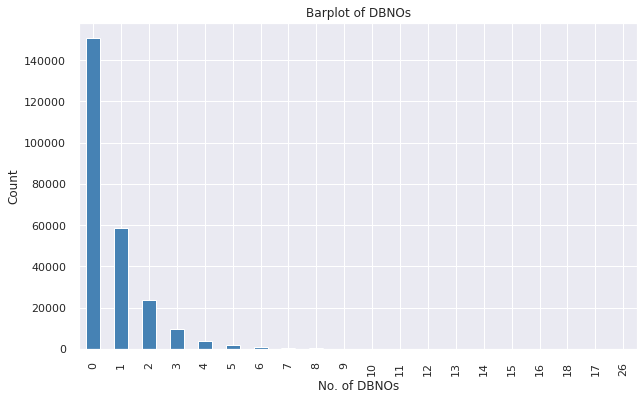

In [31]:
eda.bar_plot(train, 'DBNOs')

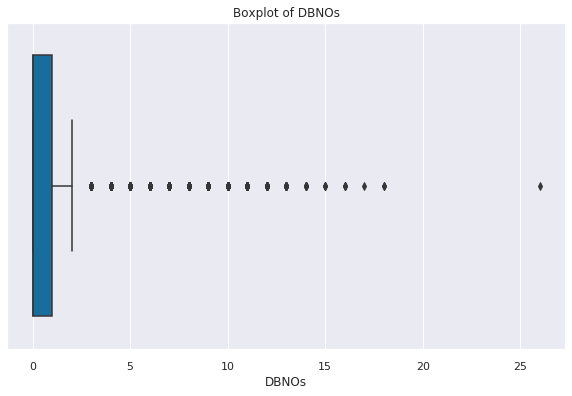

In [32]:
eda.box_plot(train, 'DBNOs')

In [33]:
eda.get_quantiles(df, 'DBNOs')

,DBNOs
0.01,0.0
0.25,0.0
0.50,0.0
0.75,1.0
0.95,3.0
0.99,5.0


> NOTES:

- Looks, like we have lot of outliers, but it could just show a highly skilled player vs. novice, and average players, as it's not normal to have more than 5 *knocked out* players. While, something like having ~25 *knocked out* players is highly unusual or sign of cheating.

In [34]:
train.query('DBNOs > 20')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
31991,26,0,0,0.0,byzone,1708,squad,0,0,61,0,0,0.0,Desert_Main,886bdfbd-bd35-41d1-9e9f-b733dfeaf0ea,steam,e0b03d58c1ad4caa8d63adffda86b99,26,0.0,0,0.0,0,1462.0,0,2136.0,5,28,0.37037


> NOTES:

- Looks like this is an anomaly, as player was killed by death zone, played for more than half-hour, walked about ~ 2 kms, with no kills at all, could be sign of cheating.

##### assists - Number of enemy players this player damaged that were killed by teammates.

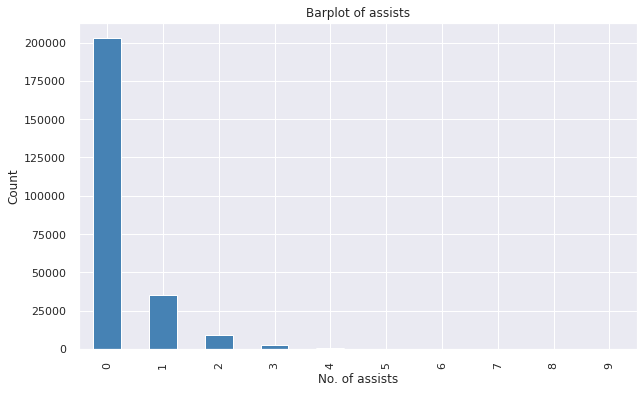

In [35]:
eda.bar_plot(train, 'assists')

In [36]:
eda.get_quantiles(df, 'assists')

,assists
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,1.0
0.99,3.0


Anything more than 8 assists looks unusual,

In [37]:
train[train['assists'] > 8]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
157039,3,9,6,582.5,byplayer,1866,squad,0,7,29,1,1,32.25,Desert_Main,3608695b-6d81-485e-a0ae-97c78f8ef483,steam,bfbdb07923fa4453867486bb17b5f636,1,2408.0,0,0.0,0,1424.0,0,3668.0,4,26,0.64
216306,5,9,5,689.0,alive,1192,squad,1,5,2,2,7,175.50,Savage_Main,3dd2a4a9-2b0b-4b45-89a1-948a5309c0a6,psn,6cb3fcf423fa4c94990f88664ab41411,1,1563.0,0,0.0,0,1192.0,0,3052.0,2,26,1.00


> NOTES:

- Doesn't look like any unusual activity by player, as other stats are not that high to signal cheating.

##### boosts - Number of boost items used 🥤

![](https://gamepedia.cursecdn.com/battlegrounds_gamepedia_en/8/8f/Icon_Boost_EnergyDrink-New.png?version=f399cfe62074e8866aaec16812d0b5bc)

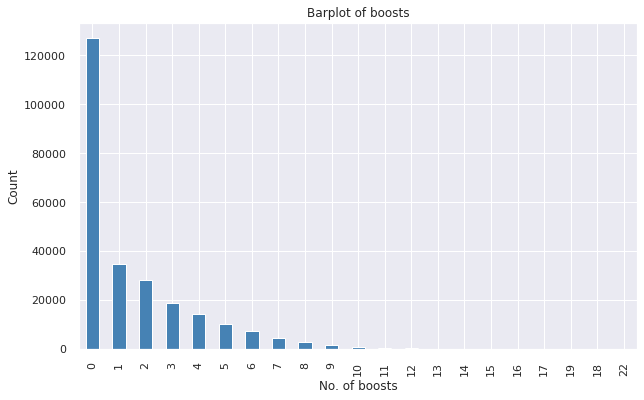

In [38]:
eda.bar_plot(train, 'boosts')

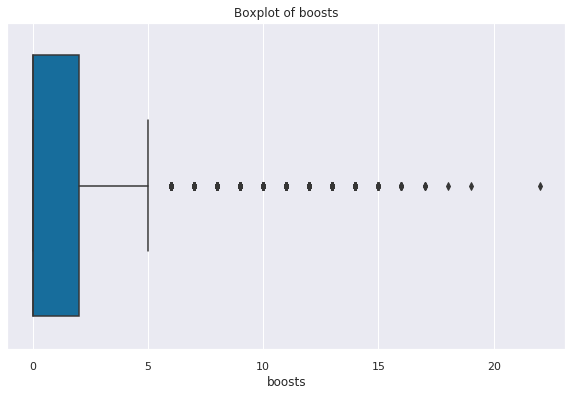

In [39]:
eda.box_plot(train, 'boosts')

> NOTES:

- When using boosting items (i.e. energy drinks) you run faster. They also help staying out of the zone (PUBG term) and loot more (meaning walking more).

- While it may not be unusual to use more than 5 boosts, but not more than 20.

In [40]:
eda.get_quantiles(train, 'boosts')

,boosts
0.01,0.0
0.25,0.0
0.50,0.0
0.75,2.0
0.95,6.0
0.99,9.0


In [41]:
train.query('boosts > 20')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
179291,4,1,22,824.5,byzone,1773,squad,2,4,1,3,8,146.125,Baltic_Main,6a6ca967-73c5-405e-9c85-e331266af444,steam,fdbfa4728af94bebbe4371f5f457510f,2,2160.0,0,0.0,0,1766.0,0,1712.0,11,26,0.96


> NOTES:

- Indeed, quite unusual amount may be or not caused due by player using cheats.

##### damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

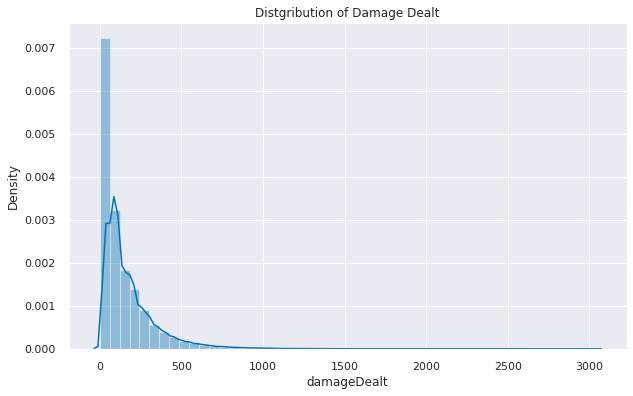

In [42]:
eda.hist_plot(train, 'damageDealt', 'Distgribution of Damage Dealt')

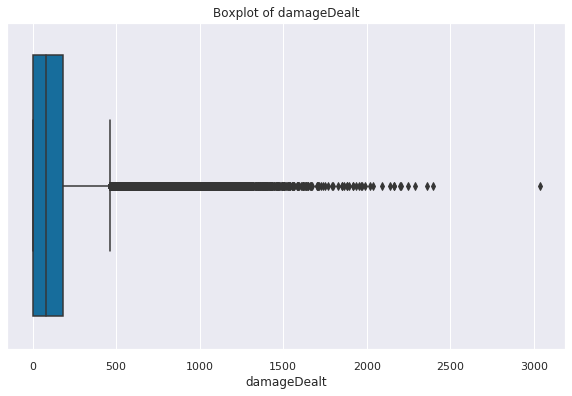

In [43]:
eda.box_plot(train, 'damageDealt')

> NOTES:

- Look's most damage dealt is ~ 750-ish, while above 2500 is just plain cheating.

In [44]:
eda.get_quantiles(train, 'damageDealt')

,damageDealt
0.01,0.000
0.25,0.000
0.50,82.125
0.75,184.500
0.95,446.250
0.99,753.000


In [45]:
train.query('damageDealt > 2500')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
89667,4,1,7,3036.0,alive,1891,squad,0,18,2,3,7,53.65625,Desert_Main,65c8a85b-aaa5-49bd-adc1-395dd27f829e,steam,d65ef5784aae41cfaf6eeaff57850033,0,3406.0,0,0.0,0,1891.0,0,2140.0,7,25,1.0


> NOTES:

- Looks like the cheater won the match 😠, has lots of `heals`, high `boosts`, with no headshot kills , but high `boosts`, indicative of using some kind of hacks or cheats.

##### duration - Amount of match duration in seconds

In [46]:
eda.get_quantiles(train, 'duration')

,duration
0.01,1223.0
0.25,1386.0
0.50,1644.0
0.75,1821.0
0.95,1947.0
0.99,2006.0


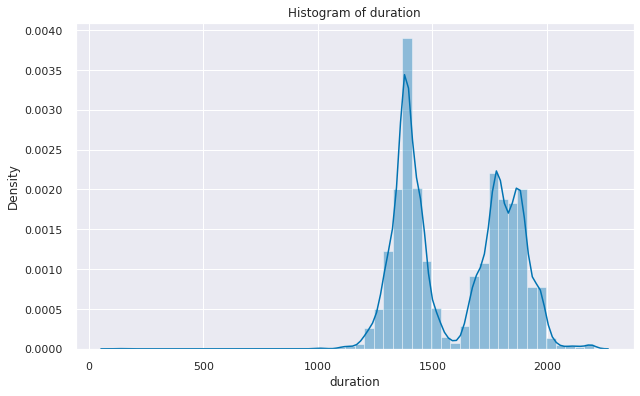

In [47]:
eda.hist_plot(train, 'duration')

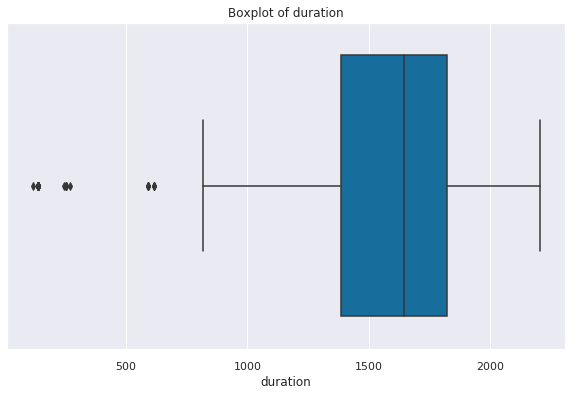

In [48]:
eda.box_plot(train, 'duration')

Let's investigate matches that are less than ~13 minutes in length

In [49]:
train.query('duration < 800')[['matchId', 'duration', 'mapName', 'gameMode', 'timeSurvived', 'deathType', 'platform', 'kills', 'maxPlace', 'walkDistance', 'winPlacePerc']].sample(10)

,matchId,duration,mapName,gameMode,timeSurvived,deathType,platform,kills,maxPlace,walkDistance,winPlacePerc
140909,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,137.125,byplayer,xbox,0,27,0.0000,0.000
202701,06b79959-c653-4dce-b9c1-249ee9f3b6ee,252,DihorOtok_Main,squad-fpp,252.125,alive,xbox,0,2,344.0000,1.000
9347,c7bc4aa5-2a93-44ab-9712-92525830dc2f,591,Savage_Main,squad-fpp,170.000,byplayer,psn,1,3,105.1875,0.000
46835,c7bc4aa5-2a93-44ab-9712-92525830dc2f,591,Savage_Main,squad-fpp,152.250,byplayer,psn,0,3,104.8750,0.500
210179,06b79959-c653-4dce-b9c1-249ee9f3b6ee,252,DihorOtok_Main,squad-fpp,244.000,byplayer,xbox,1,2,396.5000,0.000
160813,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.125,byplayer,xbox,0,27,0.0000,0.000
194430,d10afd28-ccc6-4dbe-8920-851236df9849,269,Savage_Main,duo-fpp,269.250,alive,psn,1,2,215.7500,1.000
143243,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,137.625,byplayer,xbox,0,27,0.0000,0.875
207195,bc6c378a-bac7-4e25-81d7-7f5b907fdbd8,244,DihorOtok_Main,duo-fpp,244.000,alive,psn,1,2,151.5000,1.000
22415,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.875,byplayer,xbox,0,27,0.0000,0.000


> NOTES:

- There is definitely instance of cheating going on we can further narrow down to players who died with no `walkDistance`.

In [50]:
mask = (train['duration'] < 800) & (train['walkDistance'] == 0)
train[mask]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
22415,0,0,0,0.0,byplayer,139,duo,0,0,34,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,6cd704b0683f44eba13d6f311e433048,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000
52198,0,0,0,0.0,byplayer,139,duo,0,0,48,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,8a9ceef888fa49dc889ea12740eab654,0,0.0,0,0.0,0,136.375,0,0.0,0,27,0.000000
65086,0,0,0,0.0,byplayer,139,duo,0,0,19,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,4e7e8a1866114344af4e6d8cb1d9b0fd,0,0.0,0,0.0,0,137.500,0,0.0,0,27,0.000000
69100,0,0,0,0.0,byplayer,139,duo,0,0,30,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,087908cf42df46f491030b67b44cde64,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000
78515,0,0,0,0.0,byplayer,139,duo,0,0,22,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,f6ab7d520d864dbaa1ec26e8a3228c5,0,0.0,0,0.0,0,137.125,0,0.0,0,27,0.000000
83482,0,0,0,0.0,byplayer,139,duo,0,0,39,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,b30d27b54b74429cb3414f7a646b1944,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000
83771,0,0,0,0.0,byplayer,139,duo,0,0,29,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,4a96b2cb265145308fa98ec2a3226c70,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000
93385,0,0,0,0.0,byplayer,139,duo,0,0,52,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,7c9675e067f9481ea1f18175fafed8c6,0,0.0,0,0.0,0,135.625,0,0.0,0,27,0.000000
99013,0,0,0,0.0,byplayer,139,duo,0,0,1,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,f1300421a6db4e5eafba47a664d5e552,0,0.0,0,0.0,0,139.125,0,0.0,0,27,1.000000
99853,0,0,0,0.0,byplayer,139,duo,0,0,6,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,8aac5c7bf28f4192a499d88f89548f18,0,0.0,0,0.0,0,137.375,0,0.0,0,27,0.625000


😡 Solid Cheating here, killing players off without anyone moving around, where is the fun in that. 

##### headshotKills - Number of enemy players killed with headshots

In [51]:
eda.get_quantiles(train, 'headshotKills')

,headshotKills
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,1.0
0.99,2.0


> NOTES:

- Taking more than one or two headshots is indicative of highly skilled player, which could be used as predictor of target.

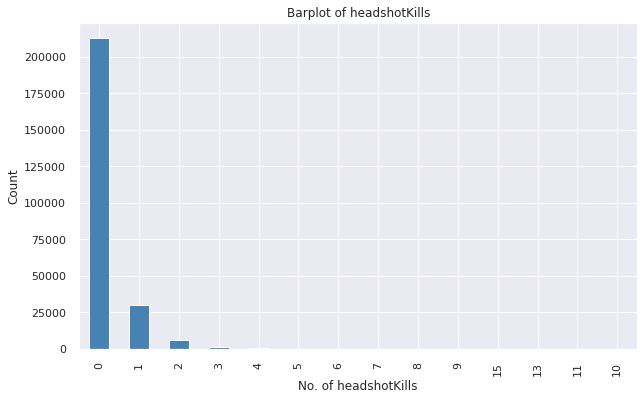

In [52]:
eda.bar_plot(train, 'headshotKills')

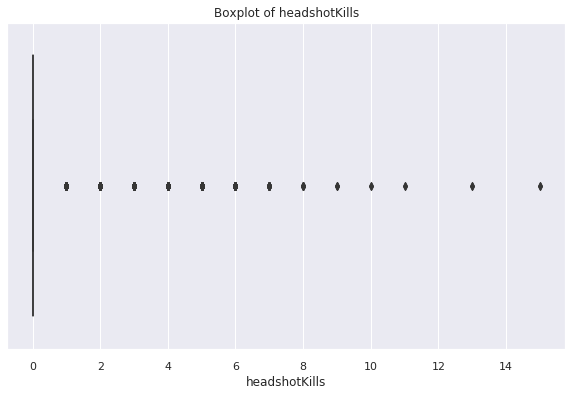

In [53]:
eda.box_plot(train, 'headshotKills')

In [54]:
train.query('headshotKills > 12')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
43703,18,1,6,2208.0,alive,1705,squad,13,3,1,13,21,345.250000,Desert_Main,993681db-619d-4866-8b76-e7d17b424c79,steam,e1211cc924104574ba87d4b0764c3006,1,4748.0,0,0.0,0,1706.0,0,2438.0,6,24,1.000000
172325,15,0,6,1988.0,alive,1771,squad,15,11,1,5,17,517.000000,Baltic_Main,774ccf7a-5511-4433-8be2-b8195bbfe13a,steam,b1d2e04b95534df78592d781db1e7ab4,1,4828.0,0,0.0,0,1771.0,0,1550.0,6,25,1.000000
181123,12,0,0,1952.0,byplayer,1626,squad,13,0,1,13,19,23.546875,DihorOtok_Main,20130732-4437-4988-a0bb-1949b5f4c42f,xbox,b10453349e5f4977940a548dfbf4c6b7,0,2852.0,0,0.0,0,617.5,0,831.5,8,27,0.576923
223034,12,0,3,2164.0,byplayer,1668,squad,15,1,1,17,22,112.000000,DihorOtok_Main,ac93c40b-0d28-42f6-a779-498f265842d7,xbox,fabb2b9e97094dbda7dc392f3f80eb4e,0,6060.0,0,0.0,0,1646.0,0,1981.0,5,28,0.925926


> NOTES:

- It's hard to tell if high headshot counts like above are unusual, or indicative of just highly skilled player mixed with cheaters using **Aim-bots**.

##### heals - Number of healing items used


In [55]:
eda.get_quantiles(train, 'heals')

,heals
0.01,0.0
0.25,0.0
0.50,0.0
0.75,2.0
0.95,8.0
0.99,14.0


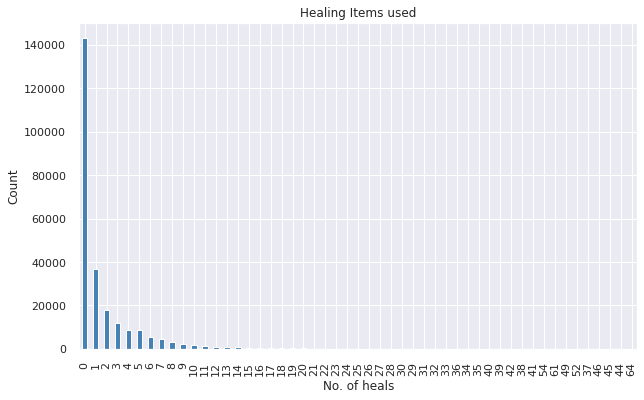

In [56]:
eda.bar_plot(train, 'heals', 'Healing Items used')

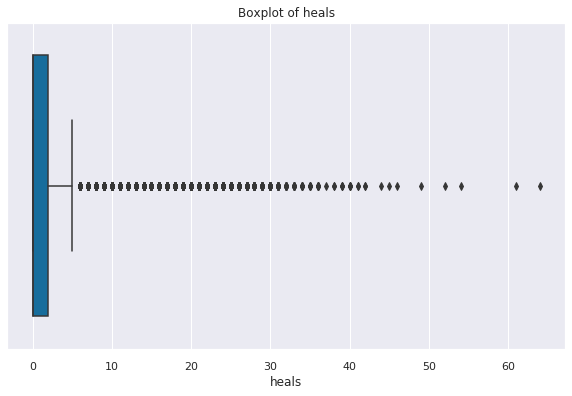

In [57]:
eda.box_plot(train, 'heals')

> NOTES:

- Since items are easily available and can be scavenged not unusual to have high amounts, while using high amounts of heals with no kills is indeed unusual. While, more than 50 is quite unusual amount of heals to take and not win the game.

In [58]:
train.query('heals > 50')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
14376,2,0,5,163.0,byplayer,1828,duo,0,52,12,1,2,15.953125,Baltic_Main,09e701c5-b343-48b9-84c3-2a6e8323cdbf,steam,7a96fe7f371643b2844893fd3d5be424,0,6468.0,0,0.0,0,1587.0,0,1026.0,6,48,0.914894
16518,1,0,7,100.0,byzone,1779,squad-fpp,0,54,23,1,1,3.818359,Baltic_Main,1c85fd38-ed6f-4450-970b-937192e3d62b,steam,8069955795b5438987d98d43e9ac394e,0,1710.0,0,0.0,0,1420.0,0,2008.0,7,37,0.750000
34329,6,0,2,590.0,byzone,1737,squad,1,64,4,4,6,13.218750,Baltic_Main,648bbaf3-3b5b-4576-97d6-667eeb506d2c,kakao,de782457f6a4d4eab80c9f288b2e8f8,0,0.0,0,0.0,0,1394.0,0,2380.0,2,26,0.680000
169377,0,0,15,0.0,byzone,1437,squad,0,61,36,0,0,0.000000,DihorOtok_Main,0f2f5979-d574-43bc-a4e0-a5bcb2474d19,steam,1e84d67d37e443a3bc7d3937cc4ed1f3,0,0.0,0,0.0,0,1352.0,0,1357.0,8,25,0.833333


> NOTES:

- Looks like they are cheating, with very few kills, and high amount of heals.

##### killStreaks - Max number of enemy players killed in a short amount of time

In [59]:
eda.get_quantiles(train, 'killStreaks')

,killStreaks
0.01,0.0
0.25,0.0
0.50,0.0
0.75,1.0
0.95,2.0
0.99,3.0


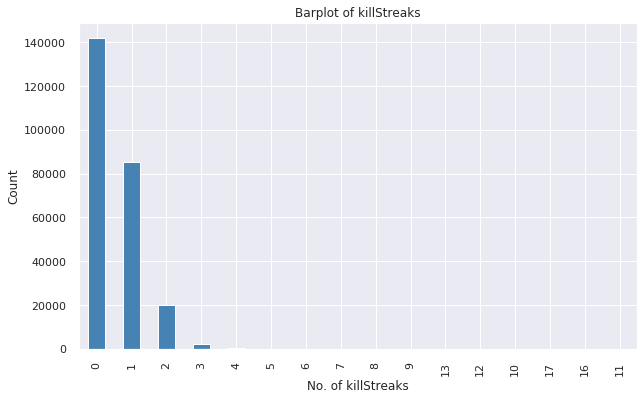

In [60]:
eda.bar_plot(train, 'killStreaks')

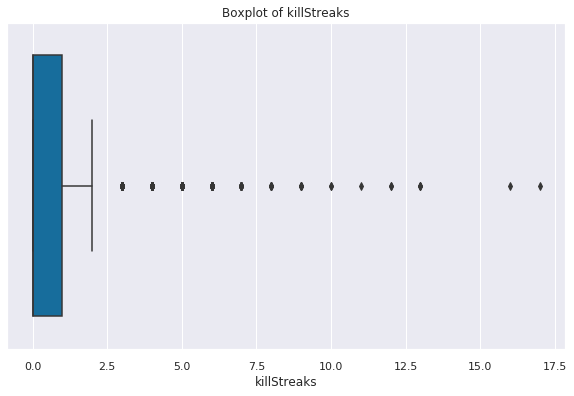

In [61]:
eda.box_plot(train, 'killStreaks')

> NOTES:

- Having high kill streaks is also unusual, as they are much harder to maintain even for a skilled player with assists of **Auto-Aim bots** or other hacks.

In [62]:
train.query('killStreaks > 15')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
201213,10,0,2,1850.0,byplayer,1658,squad,1,0,1,16,17,36.59375,DihorOtok_Main,764651d1-44dd-4ab1-a337-b333631ed2d1,xbox,48cb145fe9fa4f2289d44beaa7914b5e,0,856.5,16,0.0,0,1331.0,0,2790.0,4,23,0.772727
223034,12,0,3,2164.0,byplayer,1668,squad,15,1,1,17,22,112.00000,DihorOtok_Main,ac93c40b-0d28-42f6-a779-498f265842d7,xbox,fabb2b9e97094dbda7dc392f3f80eb4e,0,6060.0,0,0.0,0,1646.0,0,1981.0,5,28,0.925926


##### kills - Number of enemy players killed

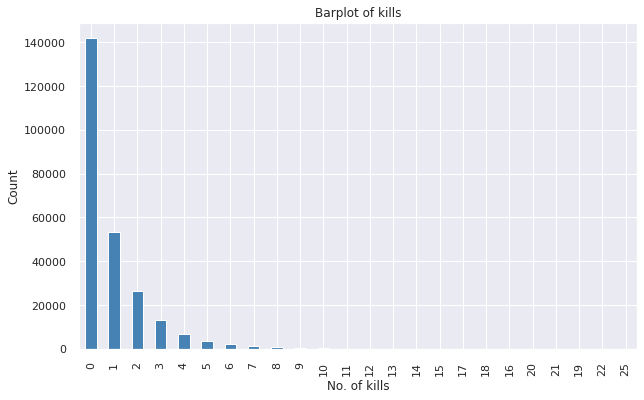

In [63]:
eda.bar_plot(train, 'kills')

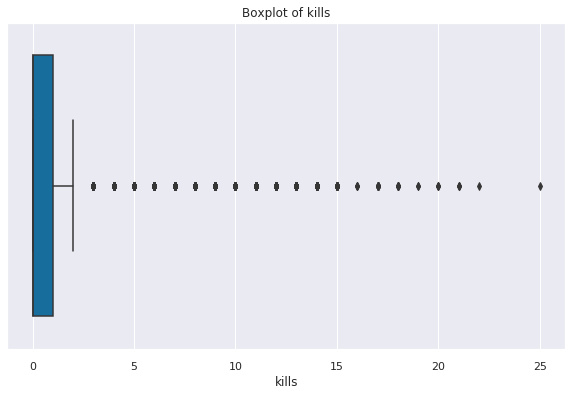

In [64]:
eda.box_plot(train, 'kills')

In [65]:
eda.get_quantiles(train, 'kills')

,kills
0.01,0.0
0.25,0.0
0.50,0.0
0.75,1.0
0.95,4.0
0.99,7.0


> NOTES:

- Having high kills above 99% is indicative of your skills as a player, though cheaters might be mixed in.

##### longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.


In [66]:
eda.get_quantiles(train, 'longestKill')

,longestKill
0.01,0.00000
0.25,0.00000
0.50,0.00000
0.75,20.53125
0.95,124.93750
0.99,239.75000


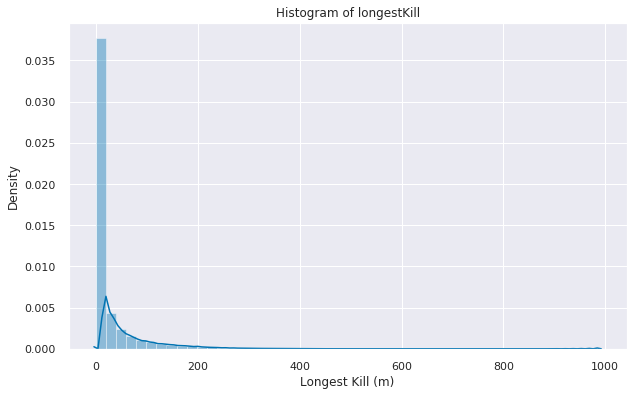

In [67]:
eda.hist_plot(train, 'longestKill', xlabel='Longest Kill (m)')

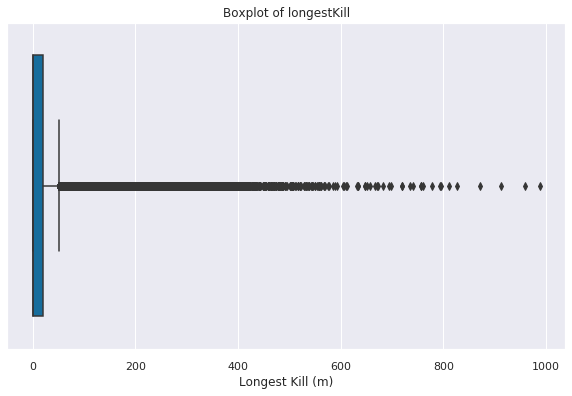

In [68]:
eda.box_plot(train, 'longestKill', xlabel='Longest Kill (m)')

##### revives - Number of times this player revived teammates

This attribute only applies to DBNO players, which means game mode would be `squad` or `duo` type.

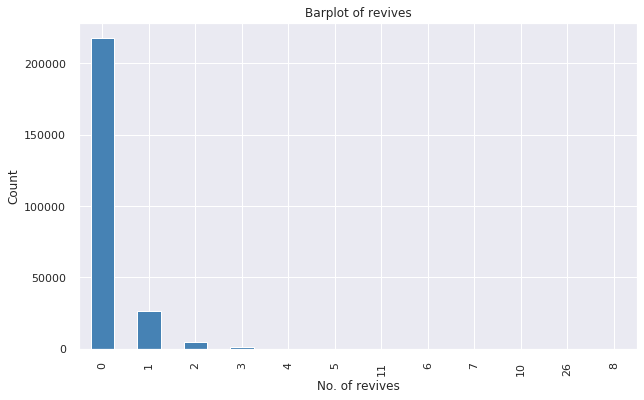

In [69]:
eda.bar_plot(train, 'revives')

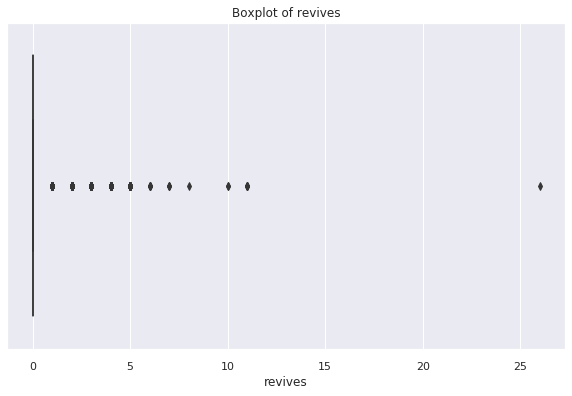

In [70]:
eda.box_plot(train, 'revives')

> NOTES:

- Definitely some of them are cheaters, when you have more than 10 revives, which is not possible when you are near enemy player that downed your teammate nearby, or under fire. 

In [71]:
train.query('revives >= 10')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
8985,10,0,2,30.203125,byplayer,1877,squad,0,4,53,0,0,0.000000,Desert_Main,2010204d-3925-4664-82ec-14ef89667ea1,steam,44cc47f0e8e4c3f99d97da93498dd4,10,2518.0,0,0.00,0,1473.00,0,2818.00,2,25,0.625000
31991,26,0,0,0.000000,byzone,1708,squad,0,0,61,0,0,0.000000,Desert_Main,886bdfbd-bd35-41d1-9e9f-b733dfeaf0ea,steam,e0b03d58c1ad4caa8d63adffda86b99,26,0.0,0,0.00,0,1462.00,0,2136.00,5,28,0.370370
59252,13,0,0,0.000000,byzone,1305,squad,0,1,53,0,0,0.000000,Savage_Main,dcaaf7aa-6251-4f0d-9c5c-d21f1eed4428,kakao,58b0ef0d5d79410a8263393a30464ede,10,0.0,0,139.25,3,977.00,0,439.75,2,27,0.538462
67247,13,0,0,100.000000,byplayer,1897,duo,0,0,35,1,1,0.992188,Erangel_Main,4413285d-a843-4b1f-8970-3ecfde716b1a,xbox,3893ed93cc314a19b11b3eb0da509af1,11,0.0,0,0.00,1,954.50,0,325.00,3,47,0.434783
67770,11,0,0,24.593750,byplayer,1406,squad,0,0,61,0,0,0.000000,Savage_Main,e0633acf-a55b-4f2c-bde1-960273d8779c,steam,d5fb356ee340435d92dc55df12c8c91f,11,0.0,0,0.00,0,643.00,0,1455.00,2,29,0.607143
141902,12,0,0,0.000000,byplayer,1744,squad,0,0,63,0,0,0.000000,Baltic_Main,ea3f1e9e-130a-464c-b4e9-3bc1381b4f26,kakao,b44b69d1fe5848bab3d1447a7f4e5992,11,0.0,0,0.00,1,707.50,0,346.00,7,29,0.428571
142757,3,0,0,0.000000,byplayer,1859,squad,0,0,70,0,0,0.000000,DihorOtok_Main,d05598de-e237-44c3-9736-371a20503629,steam,f766d5e87c5e47aba860cd0a944ad987,11,0.0,0,0.00,0,467.25,0,557.50,2,24,0.130435
144944,12,0,0,0.000000,byplayer,1279,duo,0,0,57,0,0,0.000000,Savage_Main,18176715-98c3-4379-b2b2-b5101a74c1a1,steam,bfcbcf7e6d05485c8bd6e34d6baec5d,11,0.0,0,0.00,1,437.00,0,329.00,3,49,0.541667


##### rideDistance - Total distance traveled in vehicles measured in meters

Since maps are big, and zones keep shrinking, players have to move around, those that are on the move and constantly get the loot have good chances of winning.

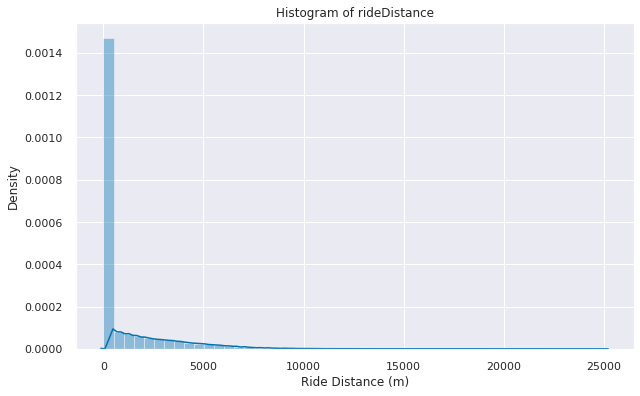

In [72]:
eda.hist_plot(train, 'rideDistance', xlabel = 'Ride Distance (m)')

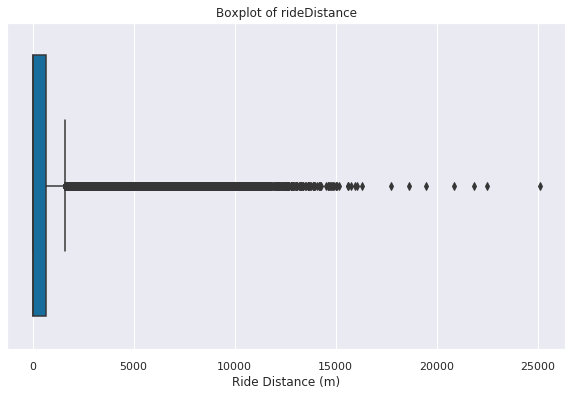

In [73]:
eda.box_plot(train, 'rideDistance', xlabel = 'Ride Distance (m)')

In [74]:
eda.get_quantiles(train, 'rideDistance')

,rideDistance
0.01,0.0
0.25,0.0
0.50,0.0
0.75,647.0
0.95,4760.0
0.99,7388.0


> NOTES:

- Anything greater than 20 km looks like players that are trolling around, let's see if they had any kills.

In [75]:
train.query('rideDistance > 20000')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
14534,0,0,9,774.5000,alive,1908,solo,1,2,1,2,9,82.6875,Erangel_Main,9447cda2-6a78-4bff-b84a-2d54877f97f6,xbox,3f6ada953c3420e98b9da78914234f,0,20848.0,6,0.0,0,1908.0,0,1289.00,3,95,1.000000
60558,0,0,0,0.0000,byplayer,1876,solo,0,0,48,0,0,0.0000,Erangel_Main,64876234-f3a4-4bad-a597-95b3470b2eed,xbox,ebc3b98b60e14dbdb9c19c94140791b0,0,21856.0,0,0.0,0,1369.0,0,326.00,5,93,0.760870
182876,0,0,0,70.1875,byplayer,1975,solo,0,0,21,0,0,0.0000,Erangel_Main,304223e5-bcff-4fae-9c2b-50eabd13465c,xbox,419df064066a46bab4ab96164e0658e5,0,22512.0,0,0.0,0,1532.0,0,400.75,7,39,0.657895
221828,1,0,1,0.0000,byplayer,1812,squad,0,2,57,0,0,0.0000,Baltic_Main,193ef378-c8f4-4eea-a898-ee00ef528f64,steam,5a2bcb6623dd4e43b3a5d59266f6350e,1,25104.0,0,0.0,0,1353.0,0,1434.00,0,26,0.640000


> NOTES:

- Indeed, except the first player, others didn't have any kills, as they were killed but surprisingly first player was a meat grinder, had 6 road kills, and one headshot.

There may be correlation between `roadKills vs. rideDistance`, after removing trolls.

In [76]:
train[['roadKills', 'rideDistance']].corr()

,roadKills,rideDistance
roadKills,1.000000,0.101728
rideDistance,0.101728,1.000000


- Very weak correlation, due to being poor strategy as it puts player into crosshairs.

##### roadKills - Number of kills while in a vehicle

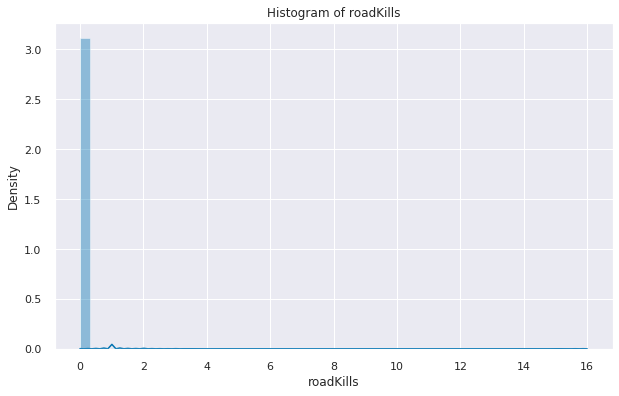

In [77]:
eda.hist_plot(train, 'roadKills')

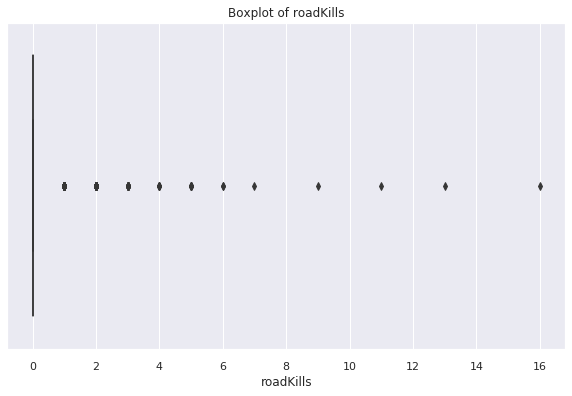

In [78]:
eda.box_plot(train, 'roadKills')

In [79]:
eda.get_quantiles(train, 'roadKills')

,roadKills
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,0.0
0.99,0.0


> NOTES:

- So, it is indeed unusual to have high `roadKills` as others would definitely shoot at you and chances of getting killed are high.

In [80]:
train.query('roadKills > 10')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
2416,5,0,1,1217.0,byplayer,2073,squad,0,1,1,5,11,5.449219,Erangel_Main,079dc24a-16be-43e1-bd05-37173bca4d27,xbox,16938b2e4b6340ecb979969f647d46b,0,4352.0,11,0.0,0,1334.000,0,1199.000000,7,26,0.720000
56558,8,0,0,1300.0,byplayer,1762,squad,0,0,1,13,13,5.769531,Erangel_Main,7c9bc90c-efe5-4a21-a0cb-3d0d6ee36186,xbox,eaa8b88fcfe04dd39c2fa07842641dd5,0,726.5,13,0.0,1,191.375,0,1.220703,0,27,0.269231
201213,10,0,2,1850.0,byplayer,1658,squad,1,0,1,16,17,36.593750,DihorOtok_Main,764651d1-44dd-4ab1-a337-b333631ed2d1,xbox,48cb145fe9fa4f2289d44beaa7914b5e,0,856.5,16,0.0,0,1331.000,0,2790.000000,4,23,0.772727


#####  swimDistance - Total distance traveled by swimming measured in meters

![](https://i.ytimg.com/vi/tQxzsE0DijQ/maxresdefault.jpg)

In [81]:
eda.get_quantiles(train, 'swimDistance')

,swimDistance
0.01,0.000000
0.25,0.000000
0.50,0.000000
0.75,0.000000
0.95,11.849219
0.99,127.621250


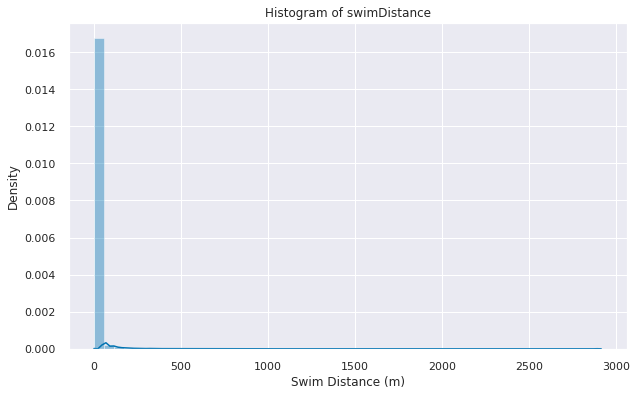

In [82]:
eda.hist_plot(train, 'swimDistance', xlabel='Swim Distance (m)')

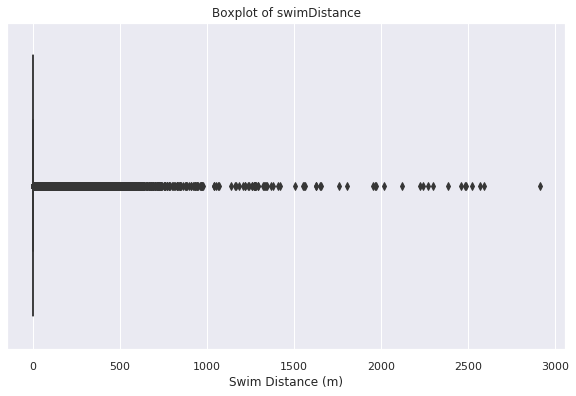

In [83]:
eda.box_plot(train, 'swimDistance', xlabel='Swim Distance (m)')

> NOTES:

- Most people don't swim, while those who swim may be swimming due to hide underneath the water.

##### teamKills - Number of times this player killed a teammate

`teamKills` could happen when players kill their teammates. This could happen for several reasons:

- Players could kill their teammates by accident such as throwing grenades at the wrong place.

- Players disconnect from the match. Teammates kill them to avoid enemies get their weapons and equipment.

- Players could kill their teammates because they behave badly.

- Players could kill their teammates just for fun.


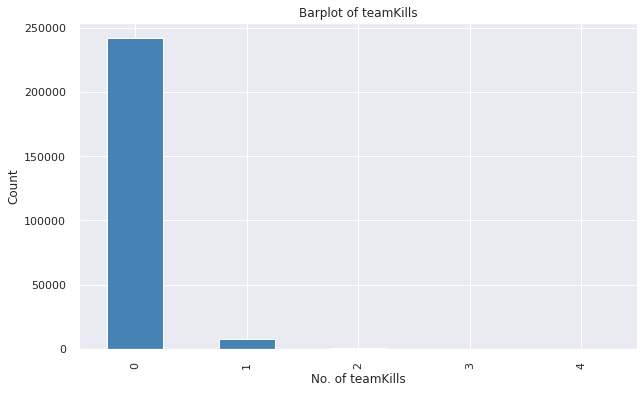

In [84]:
eda.bar_plot(train, 'teamKills')

In [85]:
train['teamKills'].value_counts()

0    241754
1      7786
2       415
3        41
4        11
Name: teamKills, dtype: int64

> NOTES:

- Definitely they have to be removed as no sane player would kill their teammates, accounting for accidental or mistakes, no more than 1 team mates, more than that would just be intentional.

In [86]:
train.query('teamKills >= 2')[['deathType', 'damageDealt', 'rideDistance', 'vehicleDestroys', 'kills', 'teamKills','winPlacePerc']].sample(15, random_state=42)

,deathType,damageDealt,rideDistance,vehicleDestroys,kills,teamKills,winPlacePerc
32345,suicide,243.87500,0.0,1,1,2,0.500000
35805,suicide,472.75000,2250.0,0,2,2,0.895833
21462,byzone,0.00000,0.0,0,0,2,0.321429
248721,suicide,148.25000,0.0,0,2,3,0.620690
42158,suicide,100.00000,0.0,0,1,2,0.538462
132655,suicide,0.00000,0.0,0,0,3,0.517241
122874,suicide,191.87500,0.0,0,3,2,0.269231
7804,byplayer,30.59375,7240.0,1,0,2,0.666667
105180,byplayer,0.00000,0.0,0,0,2,0.281250
192021,suicide,214.50000,3794.0,0,0,2,0.600000


> NOTES:
- Definitely, the `teamKills` more than or equal to 2 are just intentional as none of them intended to play seriously:
  - Those who have *vehicle destroyed* and died by *suicide* sound like players that didn't know how to drive
  - Some of them have no *damage dealt* or *kills* just died by *suicide* or *by player* or *zone*. 

##### timeSurvived - Amount of time survived measured in seconds

Since the game depends on last player survived without being killed, it implicitly means longer you survive higher your chances of winning, but not necessarily if you get killed, while it depends on amount of players in the game, map size, and player skills.

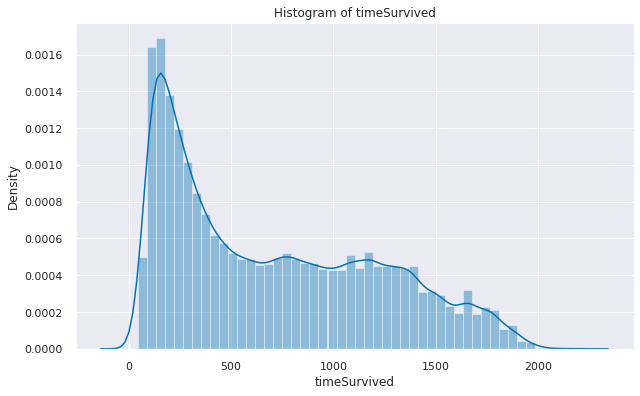

In [87]:
eda.hist_plot(train, 'timeSurvived')

##### vehicleDestroys - Number of vehicles destroyed

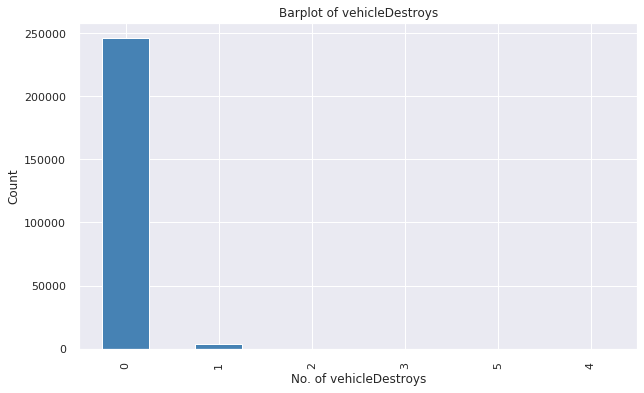

In [88]:
eda.bar_plot(train, 'vehicleDestroys')

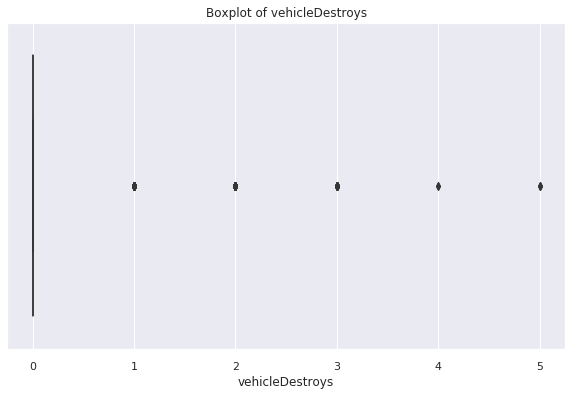

In [89]:
eda.box_plot(train, 'vehicleDestroys')

In [90]:
eda.get_quantiles(train, 'vehicleDestroys')

,vehicleDestroys
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,0.0
0.99,1.0


> NOTES:

- Looks like most people don't destroy vehicle, those that destroy could use that to their advantage if not they died by *suicide*.

##### walkDistance - Total distance traveled on foot measured in meters

In [91]:
eda.get_quantiles(train, 'walkDistance')

,walkDistance
0.01,0.000
0.25,185.125
0.50,796.500
0.75,1980.000
0.95,3310.000
0.99,4256.000


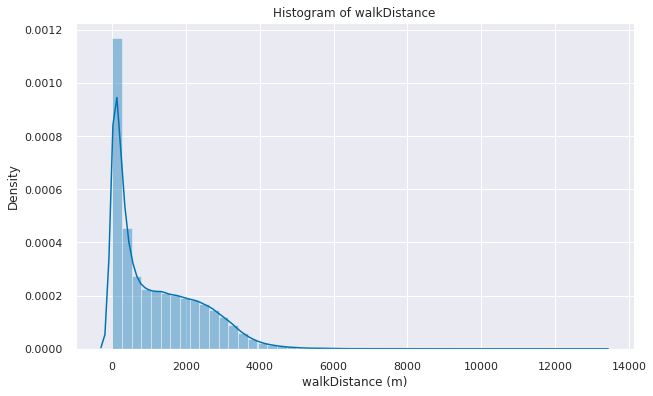

In [92]:
eda.hist_plot(train, 'walkDistance', xlabel='walkDistance (m)')

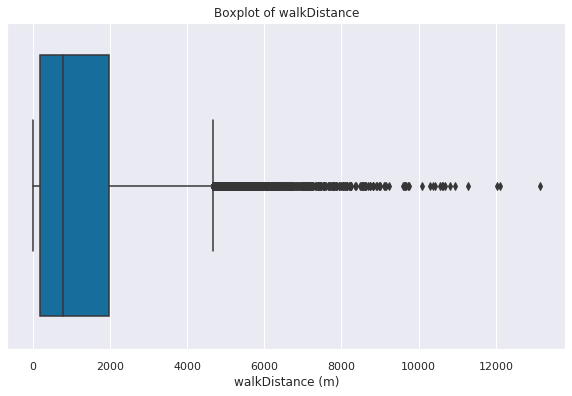

In [93]:
eda.box_plot(train, 'walkDistance', xlabel='walkDistance (m)')

> NOTES:

- We definitely have marathon runners, did they made any kills or not ?
  - Let's narrow down to those who didn't kill and just ran across the map eventually getting killed by another player, suicide or zone.

##### ☮️ The Peace lovers 🕊️



In [94]:
mask = (train['walkDistance'] > 10000) & (train['kills'] == 0)
train[mask]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
84570,0,0,3,0.0000,byplayer,1892,solo,0,5,33,0,0,0.0,Erangel_Main,cc0f1f6c-22f4-48b5-ab5a-847a7d286579,xbox,8958f352cdc34a3d825ea5965484c45b,0,0.005482,0,70.187500,0,1790.0,0,10816.0,4,95,0.914894
127266,0,0,6,0.0000,byzone,1841,duo,0,2,34,0,0,0.0,Erangel_Main,93b6a22e-1839-44c5-873e-ab2238423e05,xbox,7e264fe209704aad874b36754226cef5,0,333.750000,0,50.812500,0,1458.0,0,10080.0,4,43,0.857143
132721,0,1,7,90.9375,byplayer,1566,squad,0,13,41,0,0,0.0,Baltic_Main,7177602e-e772-49bd-a6be-7c81b9feff17,steam,60e7011b28c9496bb0f5c8ee8927b01,0,3278.000000,0,29.156250,0,1522.0,0,10944.0,4,27,0.923077
139247,0,0,4,0.0000,byplayer,1842,duo,0,5,49,0,0,0.0,Desert_Main,aad3a872-8e0d-4d0b-a13f-0e2f43063cdd,kakao,712093c17a0d40aba4c6b0c9dcccdd2,0,0.006191,0,2.230469,0,1339.0,0,10304.0,5,45,0.613636
174627,1,0,1,99.6250,byplayer,1842,duo,0,5,48,0,0,0.0,Desert_Main,aad3a872-8e0d-4d0b-a13f-0e2f43063cdd,kakao,0a3a2d99bef044e0b5c89247920dce29,0,0.001355,0,5.964844,0,1339.0,0,10688.0,4,45,0.613636
224854,0,0,2,0.0000,byplayer,1803,squad,0,4,38,0,0,0.0,Erangel_Main,b55426ed-b40c-4ec8-b632-0d6dbb34538b,psn,f47ce945489945de9b29071c349427b,1,61.625000,0,21.906250,0,1545.0,0,10416.0,4,27,0.846154
240540,0,0,2,24.9375,byzone,1870,solo,0,10,37,0,0,0.0,Erangel_Main,6b3490cd-093c-4915-b643-2abae4d67a14,xbox,721a40dfcd6f4f75b0d43d91b3b2403,0,0.005138,0,134.000000,0,1624.0,0,10632.0,5,93,0.945652


WOW! Interestingly, if you just run around the map without any kills, you still have high chance of winning the game, by being last few players alive, as their `killPlace` is lowest, with lots of `heals`.

##### weaponsAcquired - Number of weapons picked up

In [95]:
eda.get_quantiles(train, 'weaponsAcquired')

,weaponsAcquired
0.01,0.0
0.25,2.0
0.50,4.0
0.75,5.0
0.95,8.0
0.99,11.0


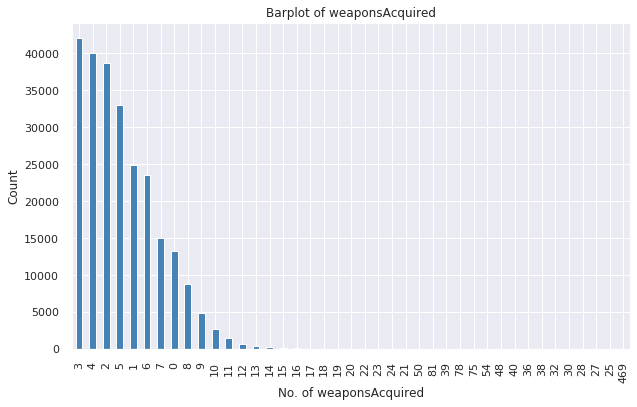

In [96]:
eda.bar_plot(train, 'weaponsAcquired')

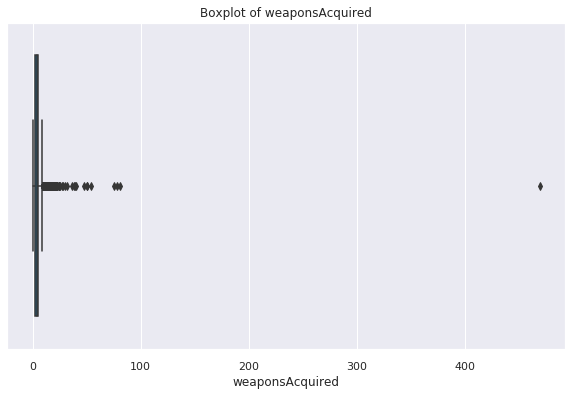

In [97]:
eda.box_plot(train, 'weaponsAcquired')

It would be unusual to even acquire more than 50 weapons and not win or have high kills in the game.

In [98]:
train.query('weaponsAcquired > 35')[['weaponsAcquired', 'platform', 'deathType', 'duration', 'kills', 'killStreaks', 'damageDealt', 'heals', 'boosts', 'winPlacePerc']]

,weaponsAcquired,platform,deathType,duration,kills,killStreaks,damageDealt,heals,boosts,winPlacePerc
15035,50,kakao,byplayer,1877,0,0,90.125,3,9,0.896552
49087,75,kakao,byplayer,1690,2,1,293.000,2,1,0.678571
67172,38,steam,byplayer,1856,0,0,0.000,0,3,0.280000
95918,40,steam,byplayer,1744,0,0,127.375,7,4,0.631579
96660,39,psn,byplayer,1389,0,0,40.250,5,2,0.461538
152364,54,kakao,byplayer,1370,1,1,100.000,1,1,0.600000
163185,469,steam,byzone,1724,1,1,144.625,2,1,0.695652
170989,50,steam,byzone,1827,0,0,0.000,26,8,0.886598
174024,78,steam,byplayer,2019,0,0,178.125,3,6,0.840000
176692,36,steam,byplayer,1763,0,0,74.000,5,1,1.000000


We did found the cheater, who has 469 `weaponsAcquired`, with 1 kill, got killed by a zone, they might be trying out the cheats. Some of the console players may be legit., while PC players are doubtful.

In [99]:
train.query('playerId == "account.4fb8997e7eee47c6b716afb2847e0ae7"')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc


##### killPlace - Ranking in match of number of enemy players killed ⚠️ May cause leakage

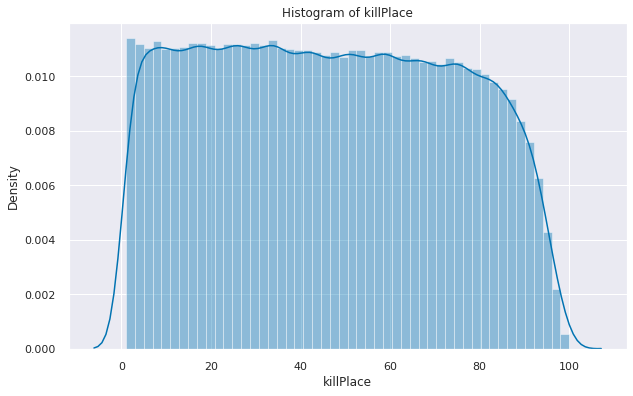

In [100]:
eda.hist_plot(train, 'killPlace')

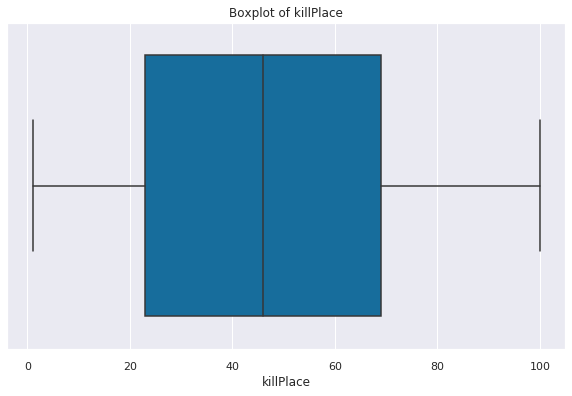

In [101]:
eda.box_plot(train, 'killPlace')

##### ⭐ winPlacePerc - Winning probability [Target]

In [102]:
train['winPlacePerc'].describe().to_frame()

,winPlacePerc
count,250007.000000
mean,0.466603
std,0.309239
min,0.000000
25%,0.192308
50%,0.448980
75%,0.734694
max,1.000000


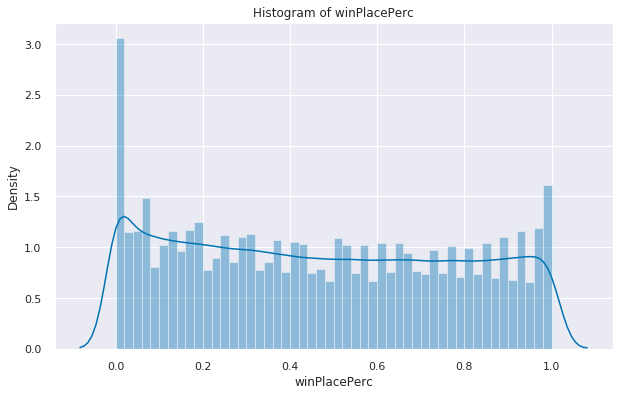

In [103]:
eda.hist_plot(train, 'winPlacePerc')

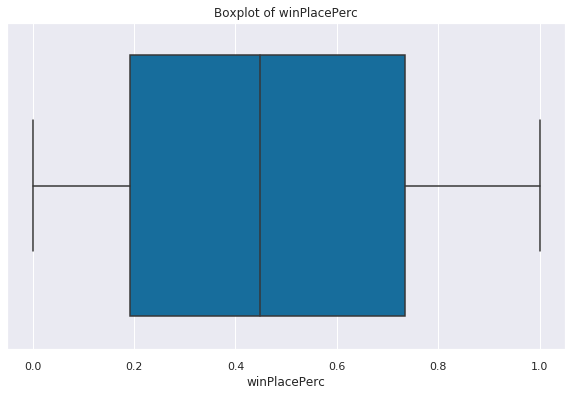

In [104]:
eda.box_plot(train, 'winPlacePerc')

#### Categorical Columns

##### deathType - The way by which this player died, or alive if they didn't ⚠️ Causes leakage

In [105]:
train['deathType'].value_counts()

byplayer    220850
byzone       16366
suicide       6815
alive         5891
logout          85
Name: deathType, dtype: int64

In [106]:
train.groupby('deathType')['winPlacePerc'].describe()

,count,mean,std,min,25%,50%,75%,max
deathType,,,,,,,,
alive,5891.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
byplayer,220850.0,0.439527,0.298694,0.000000,0.172414,0.414894,0.692308,1.0
byzone,16366.0,0.615774,0.295694,0.000000,0.434783,0.700000,0.854167,1.0
logout,85.0,0.996649,0.026547,0.758621,1.000000,1.000000,1.000000,1.0
suicide,6815.0,0.518138,0.278602,0.000000,0.314912,0.538462,0.750000,1.0


In [107]:
train[train['deathType'] == 'alive']['winPlacePerc'].value_counts()

1.0    5891
Name: winPlacePerc, dtype: int64

> NOTES:

- Indeed it causes a leakage

- It would be wise to remove players that logged out as it doesn't count as an actual engagement to play the game.

##### gameMode - Game mode played 

The standard modes are: 
 - solo or solo-fpp (FPP - First Person Player)
 - duo or duo-fpp
 - squad or squad-fpp 
 - and other modes are from events or custom matches.

In [108]:
train['gameMode'].value_counts()

squad        140978
duo           56310
solo          26789
squad-fpp     16150
duo-fpp        6340
solo-fpp       3440
Name: gameMode, dtype: int64

> NOTES:

- Looks like most players like to play in third person perspective: squad based matches, followed by duo and solo matches. This trend is similar in first person perspective matches as well.


##### mapName - There are 4 main type of maps:
- Erangel (Alpha Map) - a Russian Map
- Desert (Miramar) - a Central American map
- Savage (Sanhok) - a Southeast Asian forest map
- Snow (Vikendi or Dihorotok) - an Adriatic island snow map

In [109]:
train['mapName'].value_counts()

Savage_Main       122191
Baltic_Main        46711
Erangel_Main       32127
Desert_Main        31067
DihorOtok_Main     17911
Name: mapName, dtype: int64

> NOTES:

- Looks like most players like Jungle based map, followed by Baltic, which looks codename for Snow based map, than urban based map, lastly Desert oriented map. 

- It looks like we can further simplify the categories by grouping maps into their types, that would be reflective of actual playing environment.

#### [Pairwise Analysis](#Pairwise-Analysis)

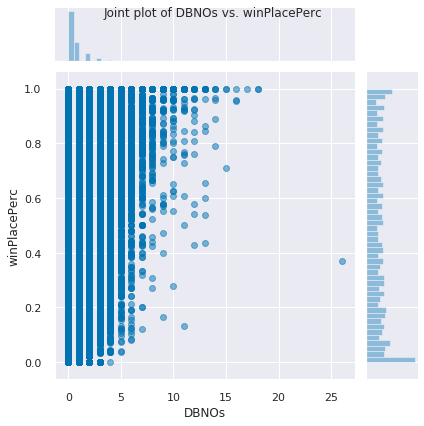

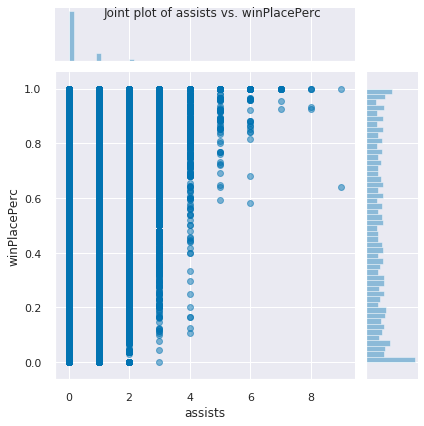

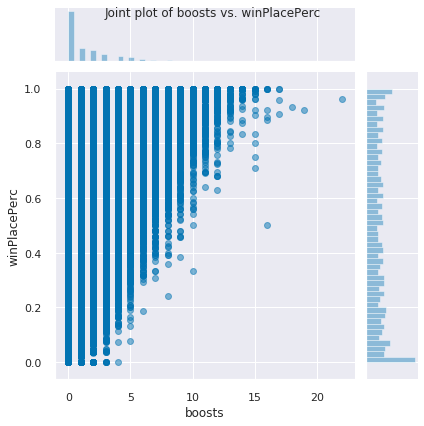

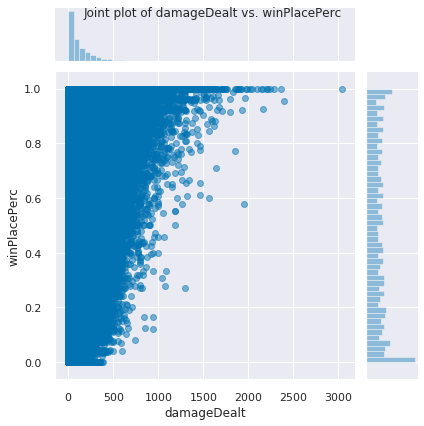

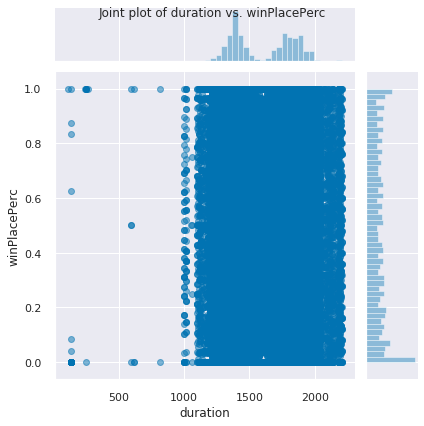

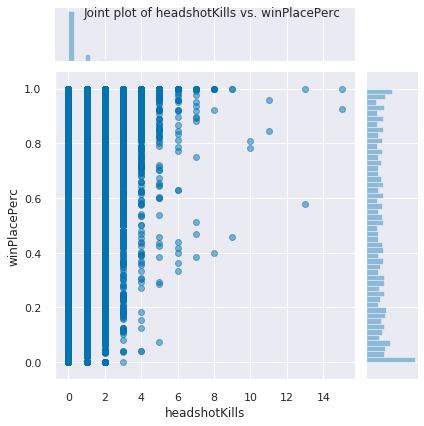

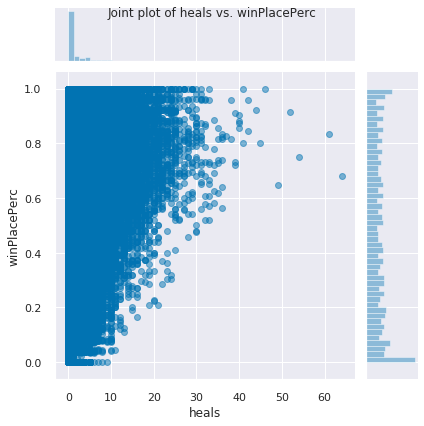

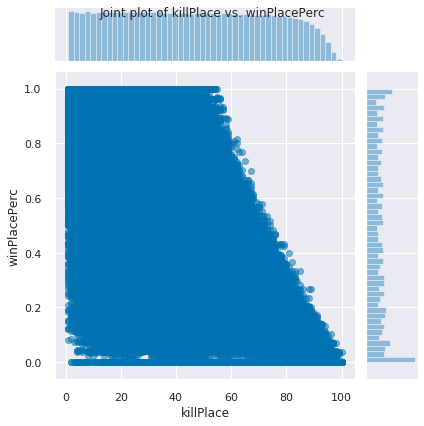

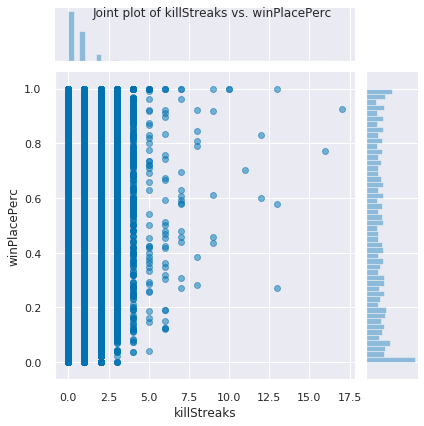

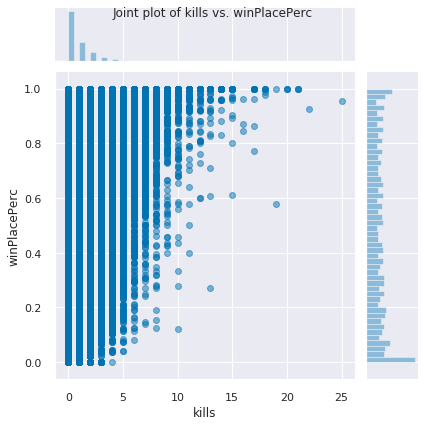

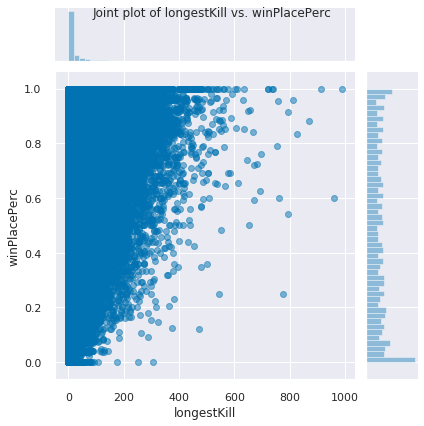

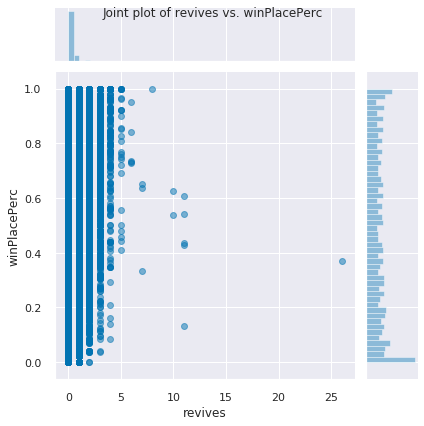

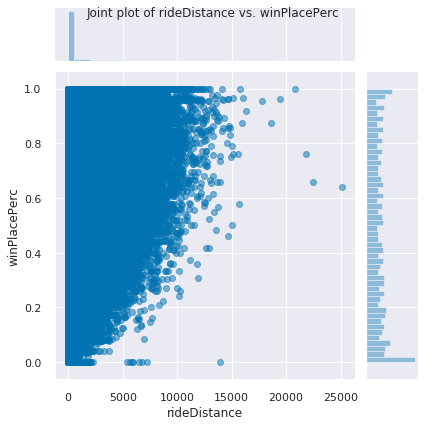

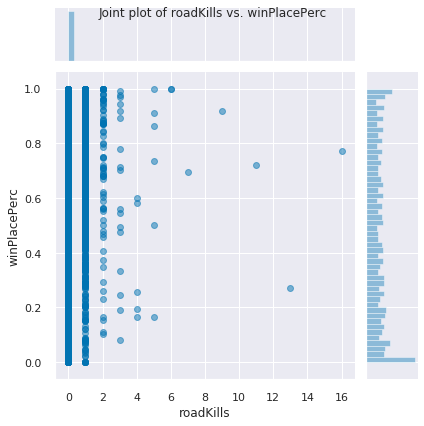

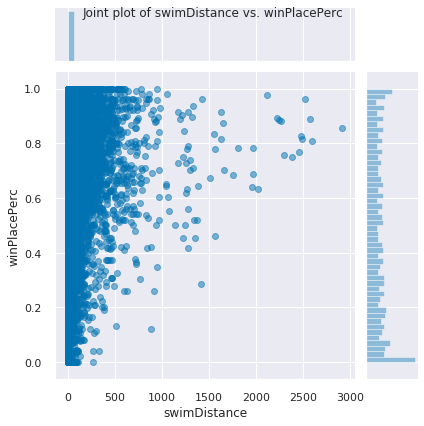

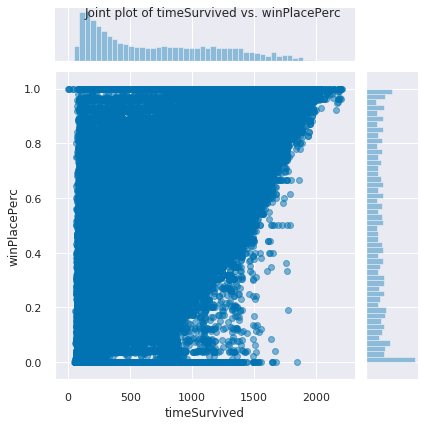

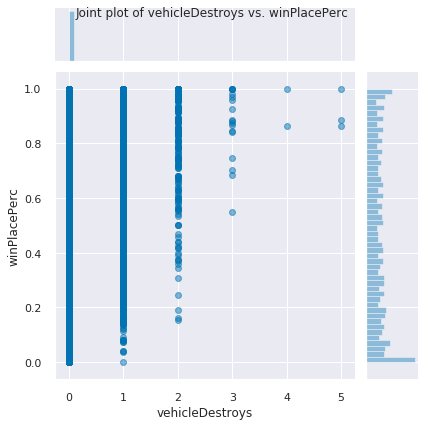

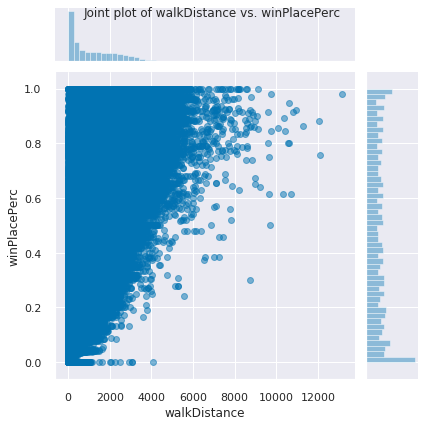

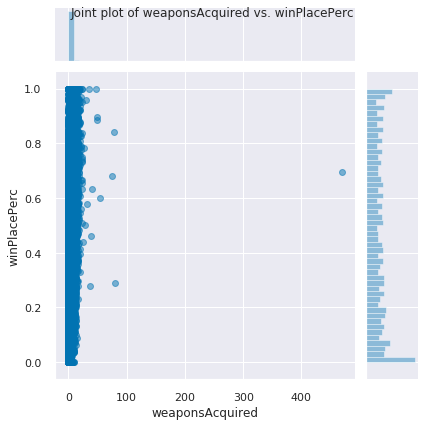

In [110]:
exclude_cols = ['maxPlace', 'winPlacePerc', 'teamKills']
numeric_cols = eda.get_numeric_columns(train)
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
target = 'winPlacePerc'

for col in numeric_cols:
    eda.joint_plot(train, col, target, alpha=0.5)

> NOTES:

- Notice the outliers:

  - DBNOs > 20
  - assists > 8
  - boosts > 20
  - damageDealt > 2500
  - duration < 800
  - heals > 50
  - revives > 15
  - rideDistance > 20000
  - roadKills > 12
  - weaponsAcquired > 100

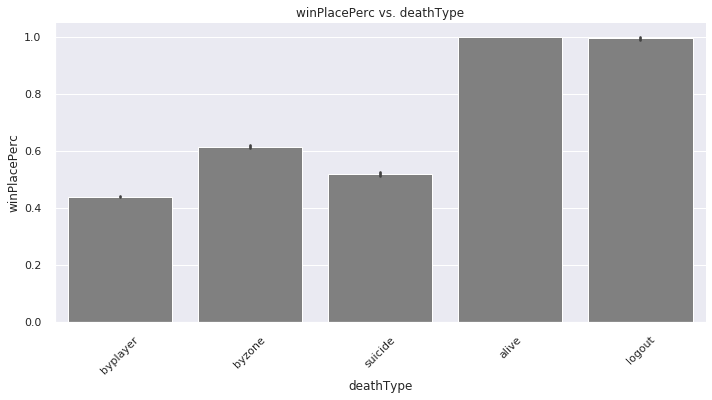

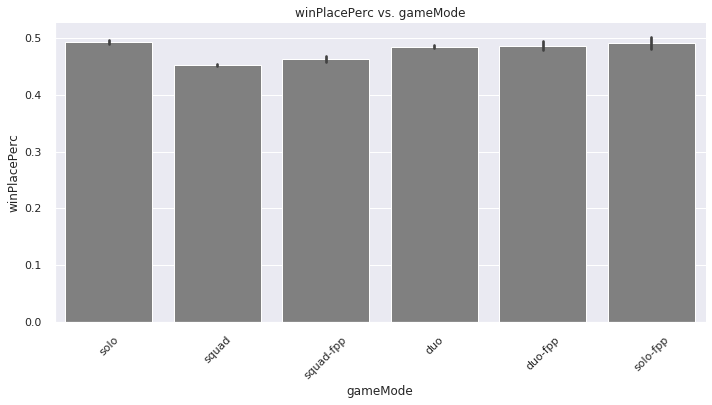

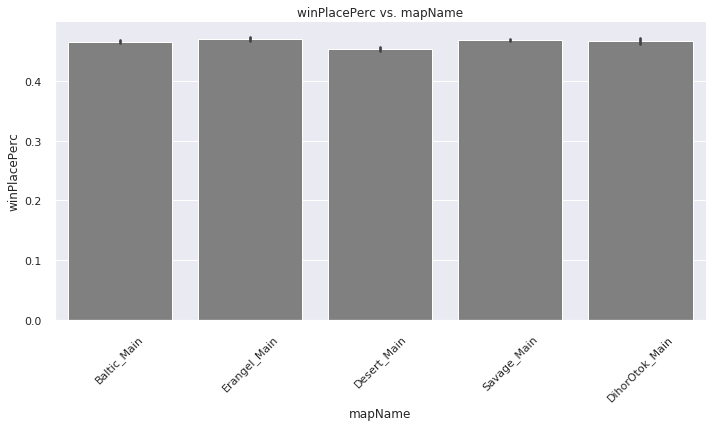

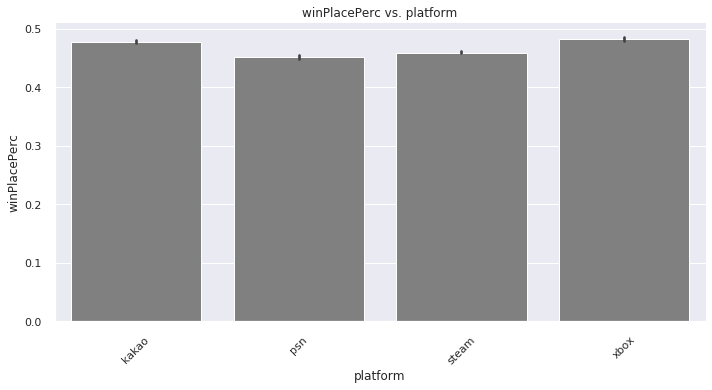

In [111]:
eda.plot_categorical_reg(train, 'winPlacePerc')

> NOTES:

- Besides `deathType` which has leakage, neither the *map type* nor any particular *platform* have any overwhelming advantage.



#### [Correlations](#Correlations)

In [112]:
numeric_cols = eda.get_numeric_columns(train)
df = train.copy()
df.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
0,0,0,2,22.4375,byplayer,1815,solo,0,4,50,0,0,0.000000,Baltic_Main,d79eab0b-4362-4194-8d53-d3187f434040,kakao,80092d0a24be4de3a6a8f7cad3fb2533,0,0.0,0,120.9375,0,1063.000,0,2886.000,5,97,0.687500
1,1,0,3,196.5000,byplayer,1885,squad,1,0,25,1,1,14.187500,Erangel_Main,8999923b-7898-4c5b-8a47-ff4ef2a9a553,psn,93f8cfbe811449898a5a31766b3a7199,0,0.0,0,0.0000,0,1411.000,0,2548.000,6,27,0.692308
2,2,0,8,183.7500,byplayer,1902,squad,0,2,8,2,3,25.078125,Desert_Main,339299e8-271b-41d9-91e0-3e86da67a7a1,steam,633c67b7a9654986bb5e6080bd091d9,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2,21,0.400000
3,0,0,0,0.0000,byplayer,1457,squad-fpp,0,0,89,0,0,0.000000,Savage_Main,29e18b9f-218f-4b47-a71e-6197cf4c7998,steam,f127a12617406f93ac66e8ee3e5c48,0,0.0,0,0.0000,0,100.750,0,37.250,2,29,0.035714
4,0,0,0,0.0000,byplayer,1422,duo,0,0,78,0,0,0.000000,Savage_Main,3279c5e8-9bb7-4444-a1d4-98b2ed5b6fa8,kakao,41f3f774292541a58955eb5d1bf294c3,0,0.0,0,0.0000,0,206.375,0,143.625,2,49,0.250000


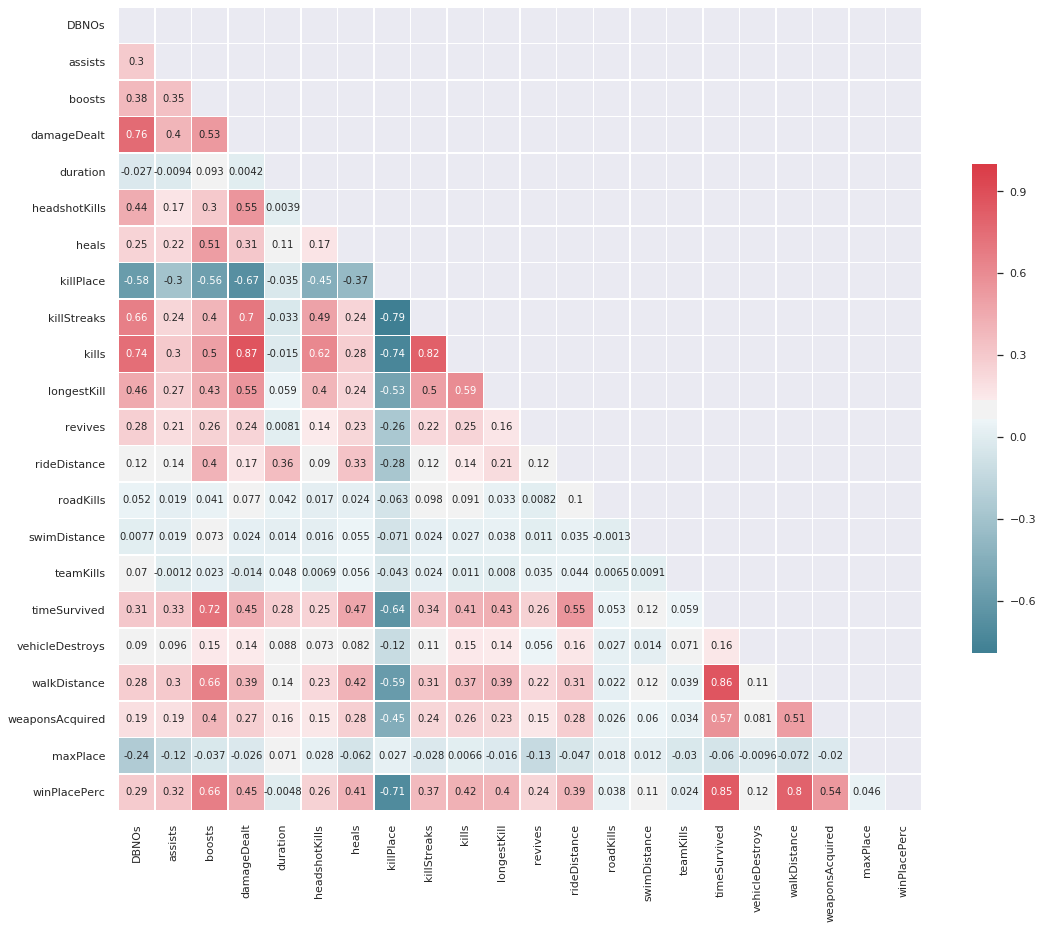

In [113]:
eda.plot_correlation_heatmap(df[numeric_cols], figsize=(18, 18))

### [Baseline](#Contents)

#### [Mean](#Contents)

In [114]:
train['winPlacePerc'].describe()

count    250007.000000
mean          0.466603
std           0.309239
min           0.000000
25%           0.192308
50%           0.448980
75%           0.734694
max           1.000000
Name: winPlacePerc, dtype: float64

Since it's a uniform distribution, we would expect to have 50-50 chances of winning. 

#### [Linear Regression](#Contents)

##### Numerical Features

In [115]:
target = 'winPlacePerc'
numeric_cols = eda.get_numeric_columns(train)
exclude_cols = ['winPlacePerc', 'maxPlace']
num_features = [col for col in numeric_cols if col not in exclude_cols]
num_features

['DBNOs',
 'assists',
 'boosts',
 'damageDealt',
 'duration',
 'headshotKills',
 'heals',
 'killPlace',
 'killStreaks',
 'kills',
 'longestKill',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'timeSurvived',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [116]:
# 1. Split X, y

X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, num_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250007, 20)
X_val : (83340, 20)
X_test : (83335, 20)
y_train: (250007,)
y_val : (83340,)
y_test : (83335,)



In [117]:
X_train.head()

,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,0,0,2,22.4375,1815,0,4,50,0,0,0.000000,0,0.0,0,120.9375,0,1063.000,0,2886.000,5
1,1,0,3,196.5000,1885,1,0,25,1,1,14.187500,0,0.0,0,0.0000,0,1411.000,0,2548.000,6
2,2,0,8,183.7500,1902,0,2,8,2,3,25.078125,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2
3,0,0,0,0.0000,1457,0,0,89,0,0,0.000000,0,0.0,0,0.0000,0,100.750,0,37.250,2
4,0,0,0,0.0000,1422,0,0,78,0,0,0.000000,0,0.0,0,0.0000,0,206.375,0,143.625,2


In [118]:
# 2. Fit Model

from sklearn.linear_model import LinearRegression

num_model = LinearRegression()
num_model.fit(X_train, y_train)

# 3. Print Metrics
eda.get_reg_metrics(num_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.8356
MSE: 0.0157
RMSE: 0.1254
MAE: 0.0931
-------- VALIDATION SET --------
R^2: 0.8364
MSE: 0.0157
RMSE: 0.1254
MAE: 0.0931


#### Numerical + Categorical features

In [119]:
### Don't select Ids which are useless, and have high cardinality to them
categorical_cols = eda.get_categorical_columns(train, min_card=1, max_card=12)
categorical_cols

['deathType', 'gameMode', 'mapName', 'platform']

In [120]:
target = 'winPlacePerc'
combined_features = categorical_cols + num_features
combined_features

['deathType',
 'gameMode',
 'mapName',
 'platform',
 'DBNOs',
 'assists',
 'boosts',
 'damageDealt',
 'duration',
 'headshotKills',
 'heals',
 'killPlace',
 'killStreaks',
 'kills',
 'longestKill',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'timeSurvived',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [121]:
# 1. Split X, y

X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, combined_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250007, 24)
X_val : (83340, 24)
X_test : (83335, 24)
y_train: (250007,)
y_val : (83340,)
y_test : (83335,)



In [122]:
X_train.head()

,deathType,gameMode,mapName,platform,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,byplayer,solo,Baltic_Main,kakao,0,0,2,22.4375,1815,0,4,50,0,0,0.000000,0,0.0,0,120.9375,0,1063.000,0,2886.000,5
1,byplayer,squad,Erangel_Main,psn,1,0,3,196.5000,1885,1,0,25,1,1,14.187500,0,0.0,0,0.0000,0,1411.000,0,2548.000,6
2,byplayer,squad,Desert_Main,steam,2,0,8,183.7500,1902,0,2,8,2,3,25.078125,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2
3,byplayer,squad-fpp,Savage_Main,steam,0,0,0,0.0000,1457,0,0,89,0,0,0.000000,0,0.0,0,0.0000,0,100.750,0,37.250,2
4,byplayer,duo,Savage_Main,kakao,0,0,0,0.0000,1422,0,0,78,0,0,0.000000,0,0.0,0,0.0000,0,206.375,0,143.625,2


In [123]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

# 2. Make Pipeline
lr_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)

lr_model.fit(X_train, y_train)

# 3. Print Metrics
eda.get_reg_metrics(lr_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.8508
MSE: 0.0143
RMSE: 0.1194
MAE: 0.0865
-------- VALIDATION SET --------
R^2: 0.8524
MSE: 0.0142
RMSE: 0.1191
MAE: 0.0862


#### k - Best Features

In [124]:
# 1. Do One-Hot encoding of categorical columns first 
X_train_encoded = lr_model.named_steps['onehotencoder'].transform(X_train)
X_val_encoded = lr_model.named_steps['onehotencoder'].transform(X_val)
X_train_encoded.head()

,deathType_byplayer,deathType_byzone,deathType_suicide,deathType_alive,deathType_logout,gameMode_solo,gameMode_squad,gameMode_squad-fpp,gameMode_duo,gameMode_duo-fpp,gameMode_solo-fpp,mapName_Baltic_Main,mapName_Erangel_Main,mapName_Desert_Main,mapName_Savage_Main,mapName_DihorOtok_Main,platform_kakao,platform_psn,platform_steam,platform_xbox,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,22.4375,1815,0,4,50,0,0,0.000000,0,0.0,0,120.9375,0,1063.000,0,2886.000,5
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,3,196.5000,1885,1,0,25,1,1,14.187500,0,0.0,0,0.0000,0,1411.000,0,2548.000,6
2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,8,183.7500,1902,0,2,8,2,3,25.078125,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2
3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.0000,1457,0,0,89,0,0,0.000000,0,0.0,0,0.0000,0,100.750,0,37.250,2
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.0000,1422,0,0,78,0,0,0.000000,0,0.0,0,0.0000,0,206.375,0,143.625,2


Text(0, 0.5, '$R^2$')

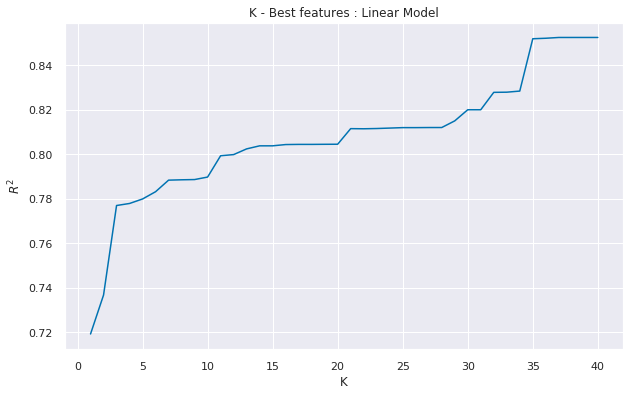

In [125]:
#  2. Plot to find k-best features
results = eda.find_k_best_features(lr_model[-1], X_train_encoded, X_val_encoded, y_train, y_val)
plt.figure(figsize=(10, 6))
plt.plot(results['K'], results['R_SQUARE'])
plt.title('K - Best features : Linear Model')
plt.xlabel('K')
plt.ylabel('$R^2$')

> NOTES:

- Looks like 35 is when $R^2$ plateaus.
- Let's print out those features

In [126]:
# Select the 35 features that gave best score
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=37)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_val_selected = selector.transform(X_val_encoded)

X_train_selected.shape, X_val_selected.shape

((250007, 37), (83340, 37))

In [127]:
# Which features were selected?
all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
print('\n')
print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
deathType_byplayer
deathType_byzone
deathType_suicide
deathType_alive
deathType_logout
gameMode_solo
gameMode_squad
gameMode_duo
gameMode_duo-fpp
gameMode_solo-fpp
mapName_Erangel_Main
mapName_Desert_Main
mapName_Savage_Main
platform_kakao
platform_psn
platform_steam
platform_xbox
DBNOs
assists
boosts
damageDealt
duration
headshotKills
heals
killPlace
killStreaks
kills
longestKill
revives
rideDistance
roadKills
swimDistance
teamKills
timeSurvived
vehicleDestroys
walkDistance
weaponsAcquired



Features not selected:
gameMode_squad-fpp
mapName_Baltic_Main
mapName_DihorOtok_Main


**Without leakage features**

In [128]:
leakage_features = ['deathType', 'killPlace']
no_leakage_features = [col for col in combined_features if col not in leakage_features]
no_leakage_features

['gameMode',
 'mapName',
 'platform',
 'DBNOs',
 'assists',
 'boosts',
 'damageDealt',
 'duration',
 'headshotKills',
 'heals',
 'killStreaks',
 'kills',
 'longestKill',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'timeSurvived',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [129]:
# 2. Split X, y
X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, no_leakage_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250007, 22)
X_val : (83340, 22)
X_test : (83335, 22)
y_train: (250007,)
y_val : (83340,)
y_test : (83335,)



In [130]:
X_train.head()

,gameMode,mapName,platform,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,solo,Baltic_Main,kakao,0,0,2,22.4375,1815,0,4,0,0,0.000000,0,0.0,0,120.9375,0,1063.000,0,2886.000,5
1,squad,Erangel_Main,psn,1,0,3,196.5000,1885,1,0,1,1,14.187500,0,0.0,0,0.0000,0,1411.000,0,2548.000,6
2,squad,Desert_Main,steam,2,0,8,183.7500,1902,0,2,2,3,25.078125,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2
3,squad-fpp,Savage_Main,steam,0,0,0,0.0000,1457,0,0,0,0,0.000000,0,0.0,0,0.0000,0,100.750,0,37.250,2
4,duo,Savage_Main,kakao,0,0,0,0.0000,1422,0,0,0,0,0.000000,0,0.0,0,0.0000,0,206.375,0,143.625,2


In [131]:
# 3. Make Pipeline & Train Model
lr_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)

lr_model.fit(X_train, y_train)

# 4. Print Metrics
eda.get_reg_metrics(lr_model, X_train, X_val, y_train, y_val, verbose=True);


-------- TRAINING SET --------
R^2: 0.8118
MSE: 0.0180
RMSE: 0.1342
MAE: 0.0951
-------- VALIDATION SET --------
R^2: 0.8166
MSE: 0.0176
RMSE: 0.1327
MAE: 0.0946


MAE increased, which was to be expected, as those features caused leakage of target, now let's see how Tree based model perform, with no leakage features.

#### [Random Forest](#Contents)

In [132]:
# 1. Split with no leakage features
X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, no_leakage_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250007, 22)
X_val : (83340, 22)
X_test : (83335, 22)
y_train: (250007,)
y_val : (83340,)
y_test : (83335,)



In [133]:
X_train.head()

,gameMode,mapName,platform,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,solo,Baltic_Main,kakao,0,0,2,22.4375,1815,0,4,0,0,0.000000,0,0.0,0,120.9375,0,1063.000,0,2886.000,5
1,squad,Erangel_Main,psn,1,0,3,196.5000,1885,1,0,1,1,14.187500,0,0.0,0,0.0000,0,1411.000,0,2548.000,6
2,squad,Desert_Main,steam,2,0,8,183.7500,1902,0,2,2,3,25.078125,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2
3,squad-fpp,Savage_Main,steam,0,0,0,0.0000,1457,0,0,0,0,0.000000,0,0.0,0,0.0000,0,100.750,0,37.250,2
4,duo,Savage_Main,kakao,0,0,0,0.0000,1422,0,0,0,0,0.000000,0,0.0,0,0.0000,0,206.375,0,143.625,2


In [134]:
from sklearn.ensemble import RandomForestRegressor

rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

)

rf_model.fit(X_train, y_train)

# 4. Print Metrics
eda.get_reg_metrics(rf_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9805
MSE: 0.0019
RMSE: 0.0432
MAE: 0.0278
-------- VALIDATION SET --------
R^2: 0.8641
MSE: 0.0131
RMSE: 0.1143
MAE: 0.0741


#### Tune the model real quick

In [135]:
# from sklearn.model_selection import RandomizedSearchCV

# pipeline = make_pipeline(
#     ce.TargetEncoder(), 
#     RandomForestRegressor(random_state=42)
# )

# param_distributions = {
#     'randomforestregressor__n_estimators': np.arange(50, 500, 10), 
#     'randomforestregressor__min_samples_split': np.arange(2, 10, 1)
# }

# search = RandomizedSearchCV(
#     pipeline, 
#     param_distributions=param_distributions,
#     n_iter=3,
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_train, y_train)
# print(search.best_params_)
# print(search.best_score_)

```
Fitting 3 folds for each of 3 candidates, totalling 9 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  7.6min remaining: 15.2min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  7.6min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 10.8min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 12.5min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 17.1min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 18.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 18.3min finished

{'randomforestregressor__n_estimators': 230, 'randomforestregressor__min_samples_split': 8}
0.8052210978164809
```

#### Re-run Model w/ Best Params

In [136]:
rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=200,
                          min_samples_split=8,                          
                          n_jobs=-1, random_state=42)

)

rf_model.fit(X_train, y_train)

# Print Metrics
eda.get_reg_metrics(rf_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9585
MSE: 0.0040
RMSE: 0.0630
MAE: 0.0389
-------- VALIDATION SET --------
R^2: 0.8659
MSE: 0.0129
RMSE: 0.1135
MAE: 0.0735


#### Feature Importances

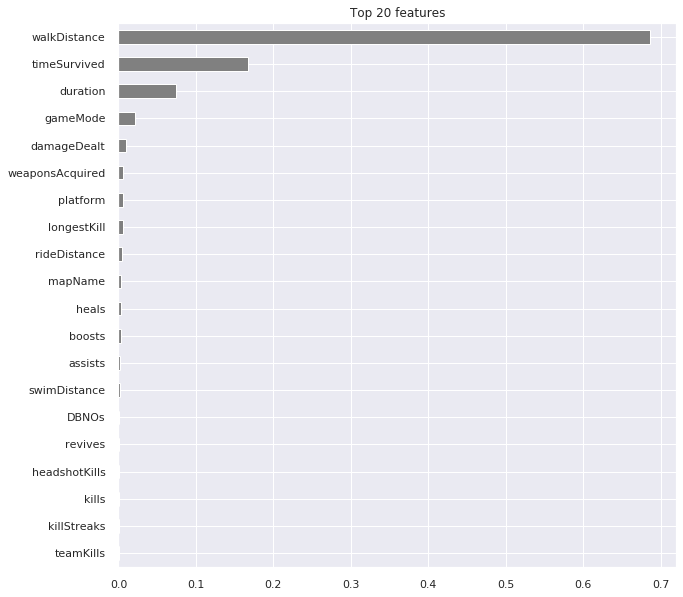

In [137]:
# Encode the categorical columns first
encoder = rf_model[0]
X_val_encoded = encoder.transform(X_val)

# Get feature names
feature_names = X_val_encoded.columns.tolist()

# Get feature importances
rf = rf_model.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, feature_names)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

#### Permutaiton Importances

In [138]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    rf_model[-1], 
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_encoded, y_val)


eli5.show_weights(
    permuter, 
    top=None, # show the permutation importances for all feature
    feature_names=feature_names
)

Weight,Feature
0.7125 ± 0.0077,walkDistance
0.3925 ± 0.0049,timeSurvived
0.1549 ± 0.0014,duration
0.0486 ± 0.0006,gameMode
0.0101 ± 0.0001,platform
0.0100 ± 0.0003,rideDistance
0.0050 ± 0.0004,weaponsAcquired
0.0049 ± 0.0006,longestKill
0.0046 ± 0.0004,mapName
0.0034 ± 0.0004,boosts


#### Save Train, Validate and Test Sets

In [139]:
to_save = {'train':train, 'validate':validate, 'test':test}
clean_dat_dir = '../datasets/clean-data'

for k, v in to_save.items():
    save_path = os.path.join(clean_dat_dir, f'{k}.csv')
    helper.save_data_frame(v, save_path)

Data Frame saved @:../datasets/clean-data/train.csv
Data Frame saved @:../datasets/clean-data/validate.csv
Data Frame saved @:../datasets/clean-data/test.csv
